In [167]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import metrics
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
    ExtraTreesClassifier, HistGradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import (
    RandomizedSearchCV, GridSearchCV, cross_val_predict
)
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, silhouette_score, recall_score,
    precision_score, make_scorer, roc_auc_score, f1_score, precision_recall_curve, accuracy_score,
    balanced_accuracy_score, fbeta_score, ConfusionMatrixDisplay
)

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

Cargamos todas las librerias que utilizaremos en este notebook, en este caso hay más por que vamos a realizar el notebook 03 hasta la parte de modelo, sin incluir esta última.

In [2]:
pd_loan_train = pd.read_csv("../data/train_pd_data_preprocessing_missing_outlier.csv")
pd_loan_test = pd.read_csv("../data/test_pd_data_preprocessing_missing_outlier.csv")

Leemos los .csv generados al final del notebook2, como siempre en una ruta relativa para que cualquiera que descargue el .zip pueda utilizar el notebook desde su dispositivo

In [3]:
pd_loan_train = pd_loan_train.drop(columns =['Unnamed: 0'])
pd_loan_test = pd_loan_test.drop(columns =['Unnamed: 0'])

Creamos los dataset de train y test, que eran con los que estabamos trabajando al final del notebook 02, eliminando la columna 'Unnamed: 0' generada al exportar los dataframes como .csv al final del notebook 02.

Reviso que en el dataframe solo tenemos las variables con las que hemos estado trabajando, en este caso coincide con las variables continuas ('float64','int64'), booleanas ('0') y categóricas ('object')

In [4]:
pd_loan_train.dtypes.unique()

array([dtype('float64'), dtype('O'), dtype('int64')], dtype=object)

Encontramos como hay variables continuas ('float64', 'int64'), no booleanas ('0') y categóricas ('object')

In [5]:
pd_loan_train['TARGET'].value_counts()

TARGET
0    226148
1     19860
Name: count, dtype: int64

Vemos la distribución que sigue el dataframe de train y quitamos la variable de estudio TARGET de la los X correspondientes a train y test ya que será la variable y como se ve a continuación:

In [6]:
X_train = pd_loan_train.drop('TARGET',axis=1)
X_test = pd_loan_test.drop('TARGET',axis=1)
y_train = pd_loan_train['TARGET']
y_test = pd_loan_test['TARGET']

A continuación, muestro, dentro de las variables categóricas, cuantos diferentes valores tiene cada variable para ver si es viable el 'OneHotEnconding' o si hay algunas a las que aplicar otro tipo de categorías

In [7]:
categorical_counts = pd_loan_train.select_dtypes(include='object').nunique()
categorical_counts_sorted = categorical_counts.sort_values(ascending=False)
print(categorical_counts_sorted)

ORGANIZATION_TYPE             58
OCCUPATION_TYPE               19
WALLSMATERIAL_MODE             8
NAME_TYPE_SUITE                8
NAME_INCOME_TYPE               8
WEEKDAY_APPR_PROCESS_START     7
NAME_HOUSING_TYPE              6
NAME_FAMILY_STATUS             6
FONDKAPREMONT_MODE             5
NAME_EDUCATION_TYPE            5
HOUSETYPE_MODE                 4
EMERGENCYSTATE_MODE            3
CODE_GENDER                    3
NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
dtype: int64


Viendo el número de valores que tiene cada variable, he decidido utilizar para todas las variables, salvo 'ORGANIZATION_TYPE' y 'OCCUPATION_TYPE', el OneHotEncoding y para las dos restantes el TargetEncoding.

In [8]:
# Definir la columna objetivo
y_train = pd_loan_train['TARGET'] # O la columna que estés usando como target
y_test = pd_loan_test['TARGET']

# Eliminar la columna objetivo de X_train (las características)
X_train = pd_loan_train.drop(columns=['TARGET'])
X_test = pd_loan_test.drop(columns=['TARGET'])

# Lista de las columnas categóricas, excluyendo 'ORGANIZATION_TYPE' y 'OCCUPATION_TYPE'
list_columns_cat = list(X_train.select_dtypes(include=["object", "category"]).columns)
list_columns_cat = [col for col in list_columns_cat if col not in ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']]

# Crear el codificador OneHotEncoder para las columnas categóricas
ohe = ce.OneHotEncoder(cols=list_columns_cat)

# Crear el codificador TargetEncoder para 'ORGANIZATION_TYPE' y 'OCCUPATION_TYPE'
te = ce.TargetEncoder(cols=['ORGANIZATION_TYPE', 'OCCUPATION_TYPE'])

# Crear un Pipeline que aplique ambos codificadores en secuencia
model = Pipeline(steps=[
    ('ohe', ohe),  # OneHotEncoder para las columnas categóricas
    ('te', te)     # TargetEncoder para 'ORGANIZATION_TYPE' y 'OCCUPATION_TYPE'
])

# Ajustar y transformar los datos
X_train_final = model.fit_transform(X_train, y_train)

In [9]:
X_test_final = model.transform(X_test) #Ajustamos el test a través del train

Aplicamos la codificación a train y luego aplicamos la codificación realizada en train a test

Verificamos que se han creado las columnas a través de la codificación, las nuevas columnas, para comprobarlo a la izq del todo, son aquellas como, p.e., NAME_INCOME_1/2/3/.../8

In [10]:
print(len(X_train_final.columns))
print(len(X_test_final.columns))

176
176


El dataset final consta de 176 columnas, se han generado 54 adicionales tras la codificación de variables.

In [11]:
X_train_final.dtypes.to_dict()

{'COMMONAREA_MEDI': dtype('float64'),
 'COMMONAREA_AVG': dtype('float64'),
 'COMMONAREA_MODE': dtype('float64'),
 'NONLIVINGAPARTMENTS_MODE': dtype('float64'),
 'NONLIVINGAPARTMENTS_AVG': dtype('float64'),
 'NONLIVINGAPARTMENTS_MEDI': dtype('float64'),
 'FONDKAPREMONT_MODE_1': dtype('int64'),
 'FONDKAPREMONT_MODE_2': dtype('int64'),
 'FONDKAPREMONT_MODE_3': dtype('int64'),
 'FONDKAPREMONT_MODE_4': dtype('int64'),
 'FONDKAPREMONT_MODE_5': dtype('int64'),
 'LIVINGAPARTMENTS_MODE': dtype('float64'),
 'LIVINGAPARTMENTS_AVG': dtype('float64'),
 'LIVINGAPARTMENTS_MEDI': dtype('float64'),
 'FLOORSMIN_AVG': dtype('float64'),
 'FLOORSMIN_MODE': dtype('float64'),
 'FLOORSMIN_MEDI': dtype('float64'),
 'YEARS_BUILD_MEDI': dtype('float64'),
 'YEARS_BUILD_MODE': dtype('float64'),
 'YEARS_BUILD_AVG': dtype('float64'),
 'OWN_CAR_AGE': dtype('float64'),
 'LANDAREA_MEDI': dtype('float64'),
 'LANDAREA_MODE': dtype('float64'),
 'LANDAREA_AVG': dtype('float64'),
 'BASEMENTAREA_MEDI': dtype('float64'),
 'BA

In [12]:
X_train_final.describe()

,COMMONAREA_MEDI,COMMONAREA_AVG,COMMONAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,FONDKAPREMONT_MODE_1,FONDKAPREMONT_MODE_2,FONDKAPREMONT_MODE_3,FONDKAPREMONT_MODE_4,...,NAME_EDUCATION_TYPE_5,NAME_INCOME_TYPE_1,NAME_INCOME_TYPE_2,NAME_INCOME_TYPE_3,NAME_INCOME_TYPE_4,NAME_INCOME_TYPE_5,NAME_INCOME_TYPE_6,NAME_INCOME_TYPE_7,NAME_INCOME_TYPE_8,SK_ID_CURR
count,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,...,246008.000000,246008.00000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000
mean,0.027898,0.028042,0.026011,0.002435,0.002657,0.002611,0.239842,0.684132,0.039283,0.018349,...,0.000557,0.17975,0.517138,0.232456,0.070473,0.000077,0.000033,0.000053,0.000020,278234.231062
std,0.043379,0.043291,0.042414,0.025223,0.026105,0.025943,0.426988,0.464861,0.194269,0.134210,...,0.023592,0.38398,0.499707,0.422399,0.255944,0.008788,0.005702,0.007269,0.004508,102832.840560
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100002.000000
25%,0.020700,0.020900,0.018900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,189152.750000
50%,0.020700,0.020900,0.018900,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,278361.000000
75%,0.020700,0.020900,0.018900,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,367267.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,456255.000000


Se va a realizar el escalado de variables de ambos dataframes, se utiliza el método estandar de la librería sklearn y el modelo escalado se entrena con X_train_final. Una vez realizado, obtenemos dos dataframes finales con el escalado de variables realizado siendo estos X_train_scaled y X_test_scaled.

In [ ]:
scaler = StandardScaler()
model_scaled = scaler.fit(X_train_final)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_final), columns=X_train_final.columns, index=X_train_final.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_final), columns=X_test_final.columns, index=X_test_final.index)

In [15]:
X_train_scaled.describe()

,COMMONAREA_MEDI,COMMONAREA_AVG,COMMONAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,FONDKAPREMONT_MODE_1,FONDKAPREMONT_MODE_2,FONDKAPREMONT_MODE_3,FONDKAPREMONT_MODE_4,...,NAME_EDUCATION_TYPE_5,NAME_INCOME_TYPE_1,NAME_INCOME_TYPE_2,NAME_INCOME_TYPE_3,NAME_INCOME_TYPE_4,NAME_INCOME_TYPE_5,NAME_INCOME_TYPE_6,NAME_INCOME_TYPE_7,NAME_INCOME_TYPE_8,SK_ID_CURR
count,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,...,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05
mean,8.904602e-17,1.557222e-16,3.272434e-17,-2.665532e-17,-5.321676e-18,1.371938e-17,3.299873e-17,-8.202025e-17,-3.788896e-17,-3.058700e-17,...,-1.494691e-18,3.676795e-17,5.645165e-17,-9.981212e-17,6.504432e-17,3.014654e-18,4.608630e-18,-1.922519e-18,-2.604878e-18,1.679975e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-6.431102e-01,-6.477491e-01,-6.132688e-01,-9.654308e-02,-1.017798e-01,-1.006368e-01,-5.617078e-01,-1.471693e+00,-2.022116e-01,-1.367186e-01,...,-2.360514e-02,-4.681249e-01,-1.034883e+00,-5.503241e-01,-2.753477e-01,-8.788585e-03,-5.702659e-03,-7.269567e-03,-4.508321e-03,-1.733226e+00
25%,-1.659224e-01,-1.649681e-01,-1.676627e-01,-9.654308e-02,-1.017798e-01,-1.006368e-01,-5.617078e-01,-1.471693e+00,-2.022116e-01,-1.367186e-01,...,-2.360514e-02,-4.681249e-01,-1.034883e+00,-5.503241e-01,-2.753477e-01,-8.788585e-03,-5.702659e-03,-7.269567e-03,-4.508321e-03,-8.662764e-01
50%,-1.659224e-01,-1.649681e-01,-1.676627e-01,-9.654308e-02,-1.017798e-01,-1.006368e-01,-5.617078e-01,6.794893e-01,-2.022116e-01,-1.367186e-01,...,-2.360514e-02,-4.681249e-01,9.662925e-01,-5.503241e-01,-2.753477e-01,-8.788585e-03,-5.702659e-03,-7.269567e-03,-4.508321e-03,1.232770e-03
75%,-1.659224e-01,-1.649681e-01,-1.676627e-01,-9.654308e-02,-1.017798e-01,-1.006368e-01,-5.617078e-01,6.794893e-01,-2.022116e-01,-1.367186e-01,...,-2.360514e-02,-4.681249e-01,9.662925e-01,-5.503241e-01,-2.753477e-01,-8.788585e-03,-5.702659e-03,-7.269567e-03,-4.508321e-03,8.658051e-01
max,2.240944e+01,2.245182e+01,2.296377e+01,3.954915e+01,3.820546e+01,3.844481e+01,1.780285e+00,6.794893e-01,4.945314e+00,7.314294e+00,...,4.236365e+01,2.136182e+00,9.662925e-01,1.817111e+00,3.631772e+00,1.137840e+02,1.753568e+02,1.375598e+02,2.218121e+02,1.731170e+00


El escalado de variables es interesante realizarlo cuando tenemos variables en escalas muy diferentes y el no realizar el escalado podría hacer que el modelo este sesgado por aquellas variables que tienen valores más grandes. Como se ha mencionado, se ha realizado el escalado estandar, cuya formula es:

$$
z = \frac{x - \mu}{\sigma}
$$

Se ha realizado este escalado por que al restarle la media (mu), los valores quedan muy cercanos a 0, esto es importante para evitar sesgos. También al dividir entre sigma lo que estoy haciendo es ajustar la dispersión de los datos, haciendo que todas las variables tengan la misma magnitud relativa. Por último puede ser interesante para la interpretación de los datos ya que como he mencionado anteriormente este método elimina las escalas y se facilita la interpretación de las contribuciones relativas de cada variable.


CONCLUSIONES

Por último tenemos las conclusiones que saco, teniendo en cuenta que aún no se ha realizado el modelo.
Las principales conclusiones son que hay ciertas variables que si parecen afectar a la hora de que los clientes tengan dificultades o no para el pago. De las comentadas en el notebook 02 despues de graficar, he seleccionado las que me parecen que pueden tener más significancia a la hora de determinar la existencia o no de dificultades.

El tipo de contrato: 
pese a que la diferencia en proporción es muy pequeña, es notable que algunos clientes tienen más dificultades  si el tipo de préstamo es 'Cash Loan', esto, como ya comenté en los gráficos, puede deberse a la diferencia en cuanto a flexibilidad entre los 'Cash loans' y los 'Revolving loans'.

La edad:

La edad a priorí era ya de suponer que iba a afectar a tener dificultades en el pago, los usuarios más jovenes, con menos tiempo de vida para haber ahorrado y tener un 'colchón financiero' más amplio, tienen aparentemente mayores dificultades para afrontar los pagos.

Empleo desempeñado:

El empleo, y por lo tanto, la fuente de ingresos del cliente, es también una variable que puede explicar si el usuario tuvo dificultades de pago, los clientes con trabajos menos cualificados tienen mayores dificultades a la hora de realizar los pagos frente a aquellos que tienen un trabajo que requiere de mayor cualificación.

Otras variables:

Otras variables que a priorí solo funcionan si se cumplen los supuestos explicados en el notebook 02 son:
- EXT_SOURCE_1,2 y 3: de la cual tenemos poca información y es simplemente información externalizada.
- FLAG_DOCUMENT_2: algo similar, no sabemos la tipología ni la información que recoge el documento, pero parece afectar el no entregarlo de cara a tener dificultades.
- DAYS_REGISTRATION/ID_PUBLISH/LAST_PHONE_CHANGE: También hice una serie de suposiciones que podrían explicar el por qué aquellos con menos días desde el cambio de documentos, registro o teléfono tuvieron más dificultades a la hora de afrontar el pago

# SELECCIÓN DE VARIABLES

Para la selección de variables, realizaré primero un un análisis con RandomForestClassifier al que añadiré una columna con datos randomizados para ver que a que variables les da más importancia que a una variable sin relación aparente con el dataset.

In [51]:
X_train_scaled['random_feature'] = np.random.rand(len(X_train_scaled))
X_test_scaled['random_feature'] = np.random.rand(len(X_test_scaled))

In [52]:
%%time
clf = RandomForestClassifier(n_estimators=300
                             ,criterion='gini'
                             ,max_depth=10
                             ,random_state=seed)
clf.fit(X_train_scaled, y_train)

CPU times: total: 3min 37s
Wall time: 3min 50s


RandomForestClassifier(max_depth=10, n_estimators=300, random_state=1441)

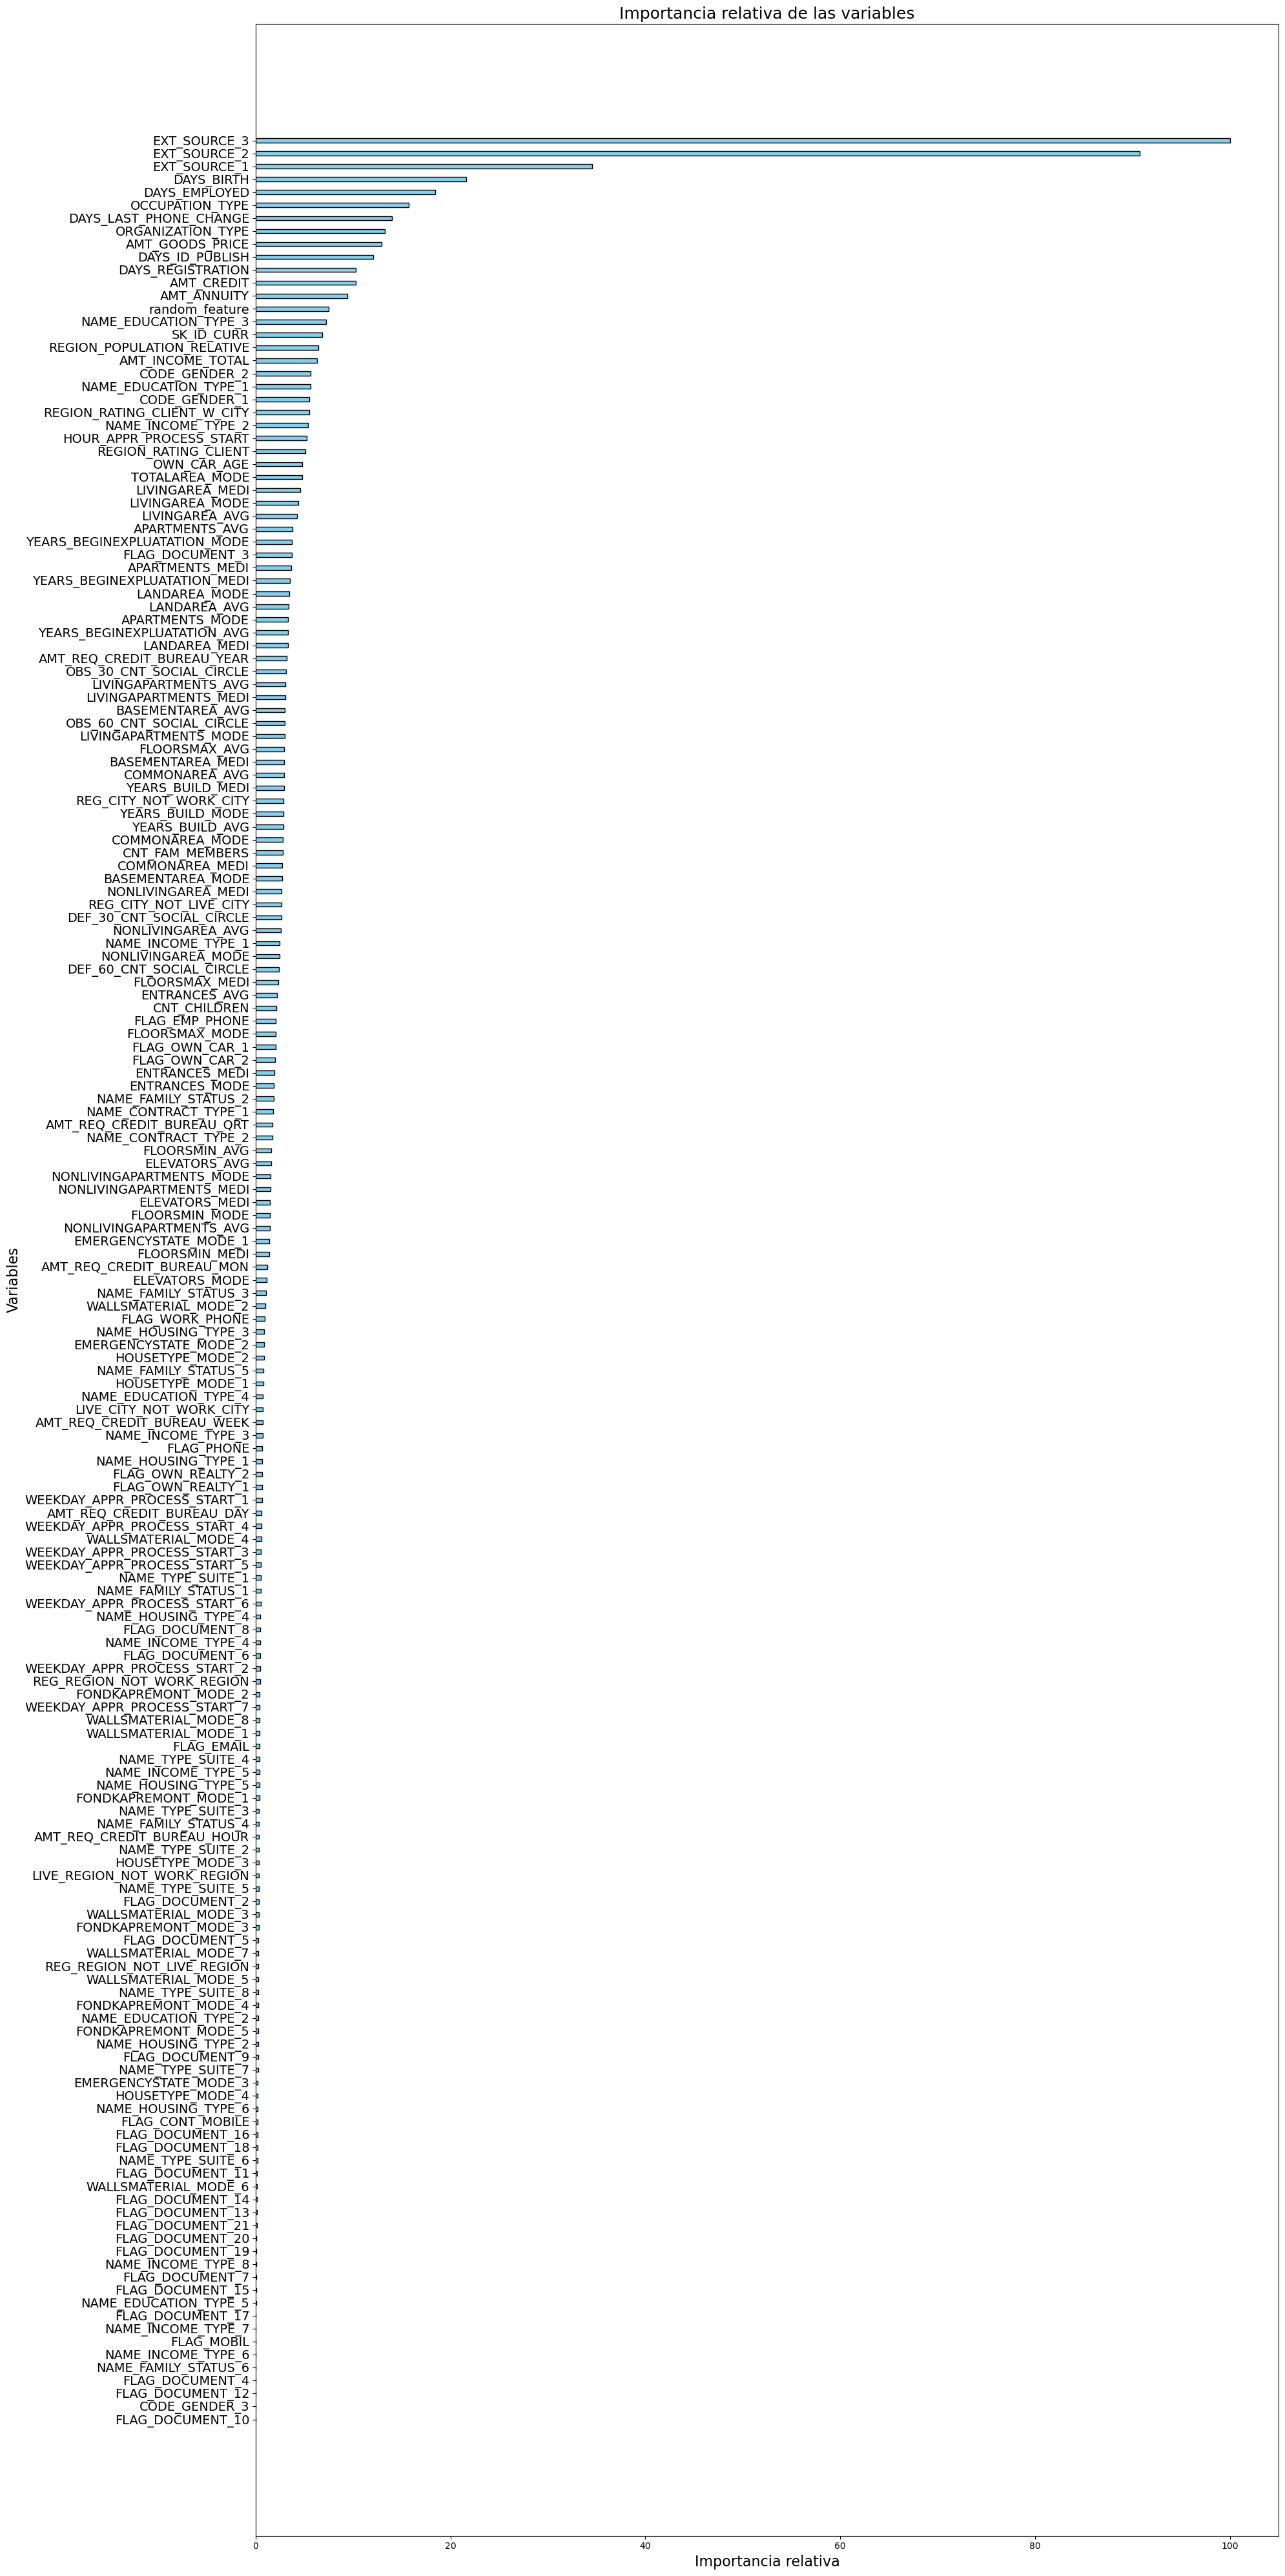

In [53]:
# Hacer las importancias relativas al máximo
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# Ordenar los índices según las importancias
sorted_idx = np.argsort(feature_importance)

# Crear posiciones con mayor separación
bar_width = 0.5  # Altura de las barras
pos = np.arange(sorted_idx.shape[0]) * 1.5  # Incrementa el espaciado entre barras

# Configuración del gráfico
plt.figure(figsize=(20, 40))  # Tamaño grande para evitar solapamientos
plt.barh(pos, feature_importance[sorted_idx], align='center', height=bar_width, color='skyblue', edgecolor='black')
plt.yticks(pos, X_train_scaled.keys()[sorted_idx], fontsize=14)  # Tamaño más grande para las etiquetas


# Configuración de los ejes y título
plt.xlabel('Importancia relativa', fontsize=16)
plt.ylabel('Variables', fontsize=16)
plt.title('Importancia relativa de las variables', fontsize=18)


# Ajustar automáticamente los espacios
plt.tight_layout()  
plt.show()

Observamos como hay un total de 15 variables a las que el modelo da más importancia que a la variable aleatoria "random_feature" que habiamos creado. Es por esto que si tuvieramos que elegir variables, sería interesante elegir aquellas que han obtenido una importancia relativa superior a la variable aleatoria. Es por esto que, en este caso, me quedaría con las siguientes variables:

- 'EXT_SOURCE_3'
- 'EXT_SOURCE_2'
- 'EXT_SOURCE_1'
- 'DAYS_BIRTH'
- 'DAYS_EMPLOYED'
- 'OCCUPATION_TYPE'
- 'DAYS_LAST_PHONE_CHANGE'
- 'ORGANIZATION__TYPE'
- 'DAYS_ID_PUBLISH'
- 'AMT_GOODS_PRICE'
- 'DAYS_REGISTRATION'
- 'AMT_CREDIT'
- 'AMT_ANNUITY'
- 'NAME_EDUCATION_TYPE_2'

SK_ID_CURR  al final no es necesaria ya que es simplemente el ID y no nos devuelve mucha información adicional

In [54]:
%%time
clf_l = lgb.LGBMClassifier(
    boosting_type='gbdt',       # Tipo de boosting, similar a RandomForest
    n_estimators=300,           # Número de árboles
    max_depth=10,               # Profundidad máxima del árbol
    objective='binary',         # Función de pérdida (puedes ajustarlo según tu problema)
    random_state=seed           # Para reproducibilidad
)

clf_l.fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.182771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11753
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 167
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
CPU times: total: 33.2 s
Wall time: 23.6 s


LGBMClassifier(max_depth=10, n_estimators=300, objective='binary',
               random_state=1441)

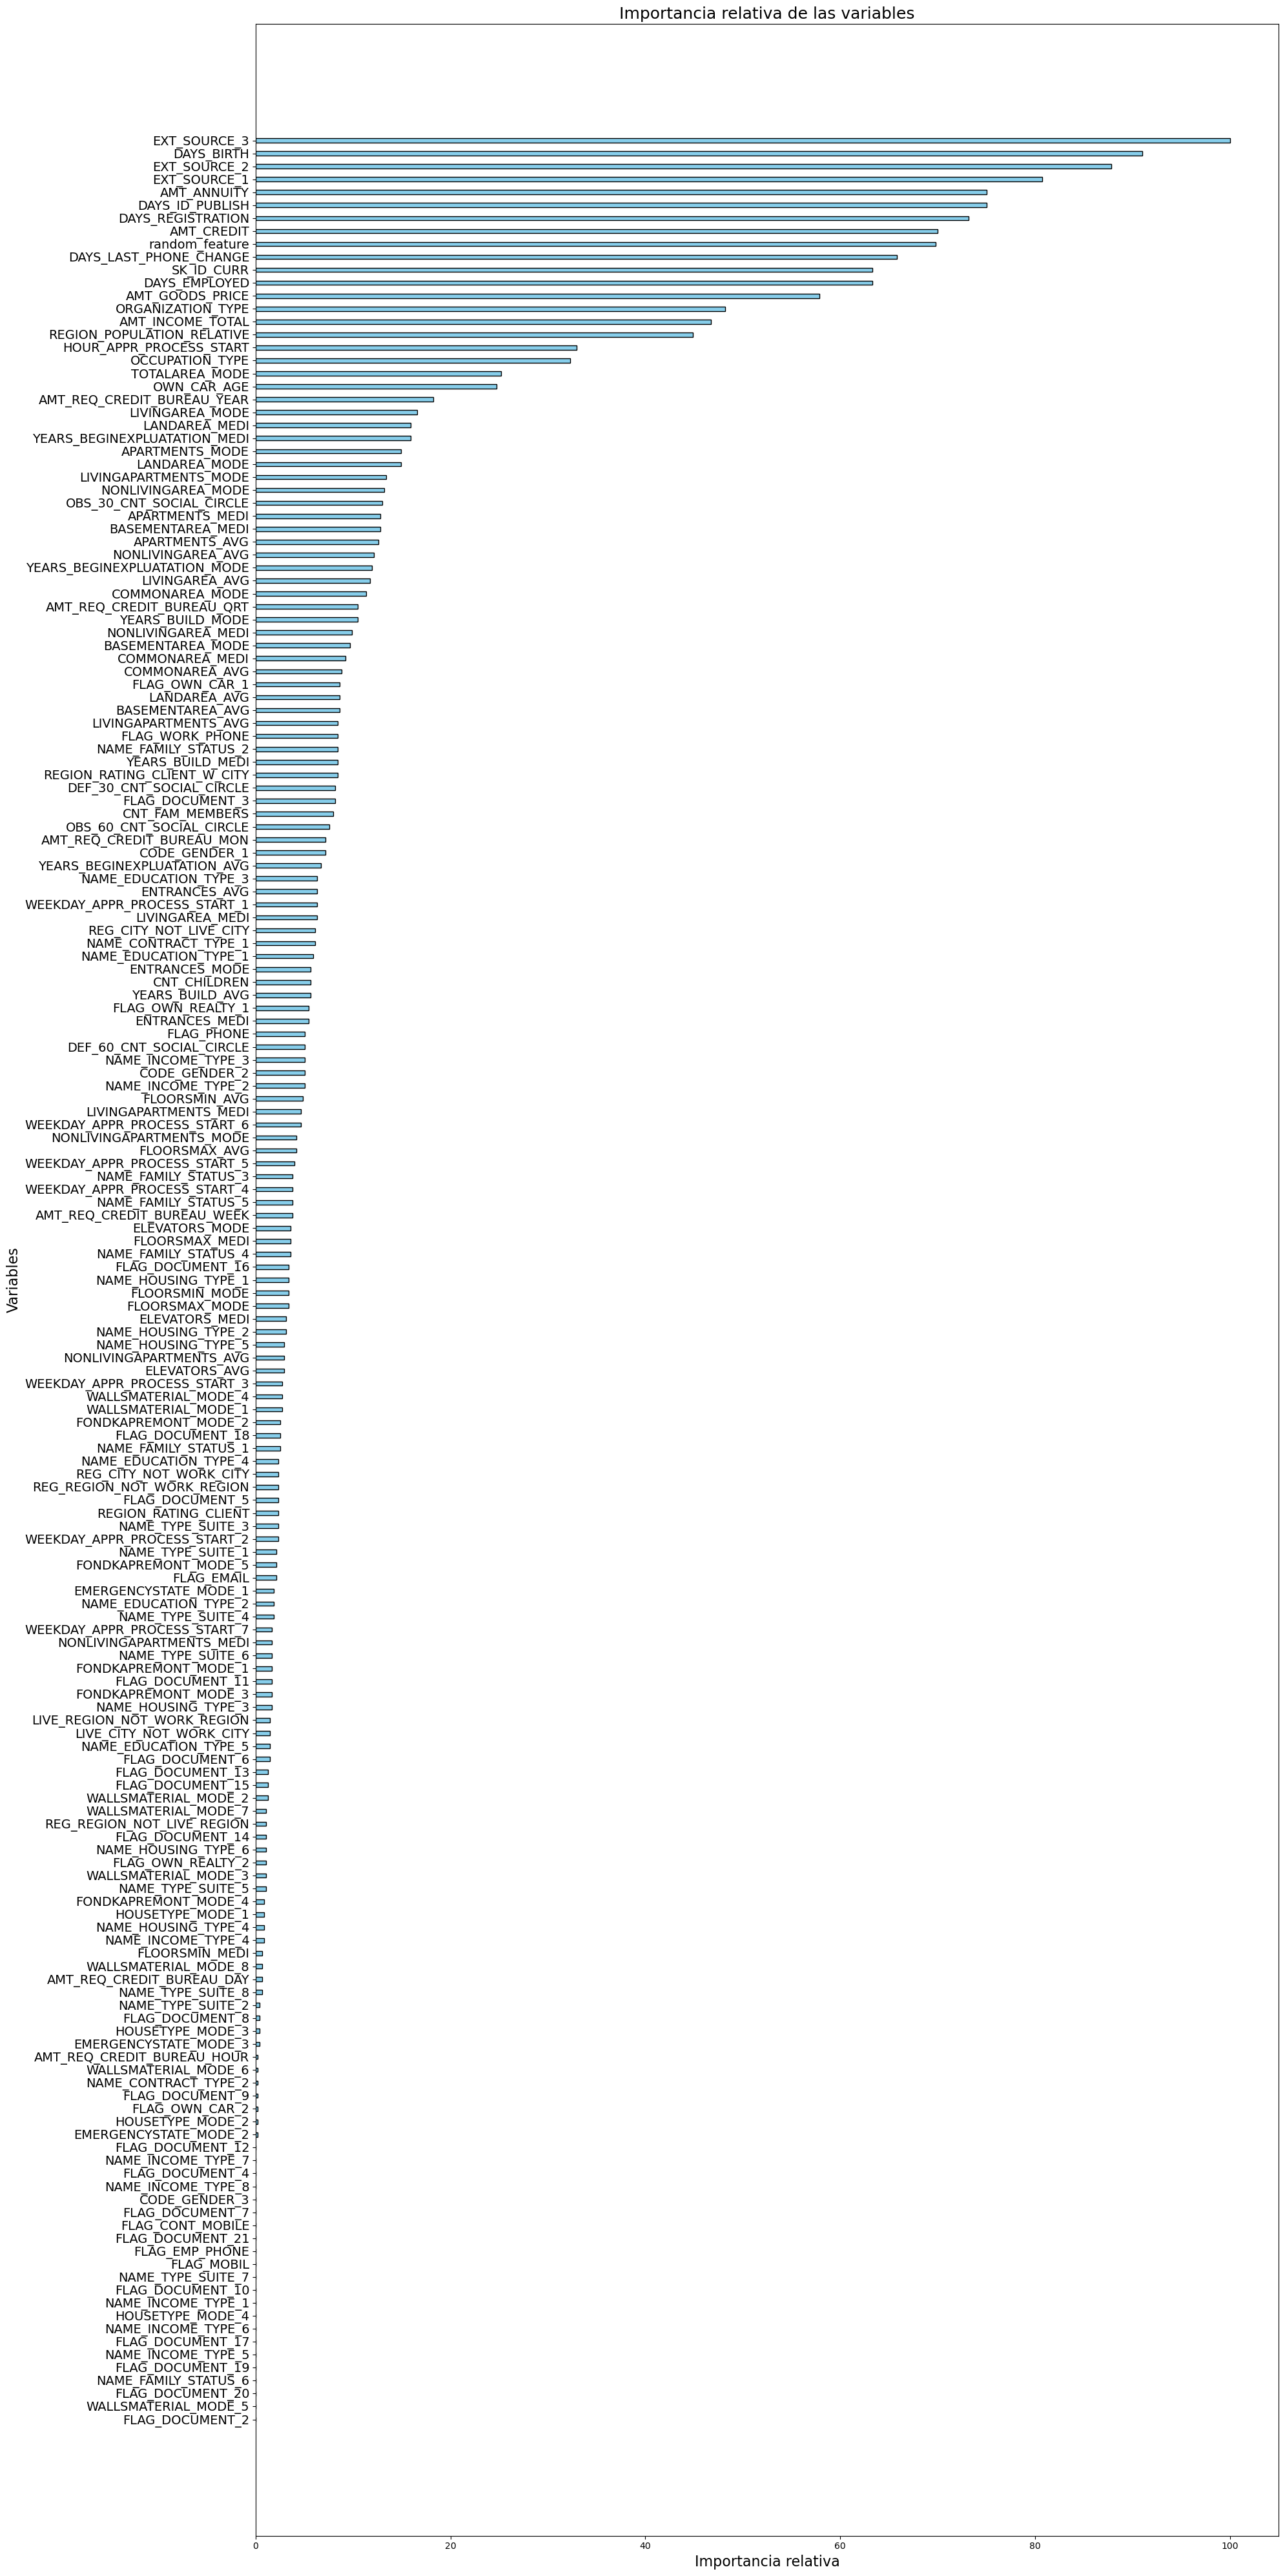

In [55]:
# Hacer las importancias relativas al máximo
feature_importance = clf_l.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# Ordenar los índices según las importancias
sorted_idx = np.argsort(feature_importance)

# Crear posiciones con mayor separación
bar_width = 0.5  # Altura de las barras
pos = np.arange(sorted_idx.shape[0]) * 1.5  # Incrementa el espaciado entre barras

# Configuración del gráfico
plt.figure(figsize=(20, 40))  # Tamaño grande para evitar solapamientos
plt.barh(pos, feature_importance[sorted_idx], align='center', height=bar_width, color='skyblue', edgecolor='black')
plt.yticks(pos, X_train_scaled.keys()[sorted_idx], fontsize=14)  # Tamaño más grande para las etiquetas


# Configuración de los ejes y título
plt.xlabel('Importancia relativa', fontsize=16)
plt.ylabel('Variables', fontsize=16)
plt.title('Importancia relativa de las variables', fontsize=18)


# Ajustar automáticamente los espacios
plt.tight_layout()  
plt.show()

Vemos como estas son las variables que han obtenido una importancia relativa superior a la variable generada artificialmente "random_feature".
    
- "EXT_SOURCE_3",
- "EXT_SOURCE_2",
- "EXT_SOURCE_1",
- "DAYS_BIRTH",
- "DAYS_ID_PUBLISH",
- "AMT_ANNUITY",
- "DAYS_REGISTRATION",
- "DAYS_EMPLOYED",
- "AMT_CREDIT",
- "DAYS_LAST_PHONE_CHANGE",


In [56]:
X_train_scaled = X_train_scaled.drop(columns=['random_feature'], errors='ignore')
X_test_scaled = X_test_scaled.drop(columns=['random_feature'], errors='ignore')

Elimino la variable random generada, cuya utilidad se limitaba a los dos supuestos anteriores.

In [18]:
sel_ridge = SelectFromModel(LogisticRegression(C=1, penalty='l2'), threshold = 0.05)
sel_ridge.fit(X_train_scaled, y_train)

SelectFromModel(estimator=LogisticRegression(C=1), threshold=0.05)

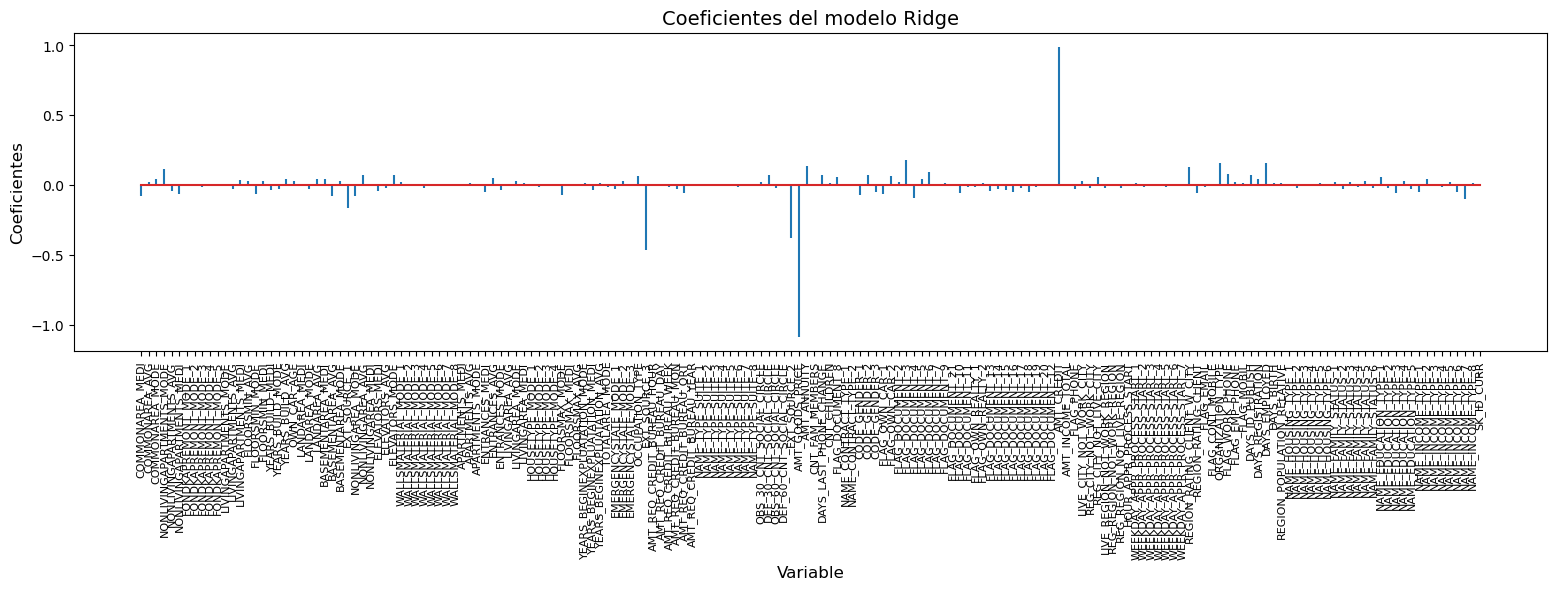

In [19]:
df_coeficientes = pd.DataFrame(
    {'predictor': X_train_scaled.columns,
     'coef': sel_ridge.estimator_.coef_.flatten()}
)

fig, ax = plt.subplots(figsize=(16, 6))  
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(
    rotation=90,  
    ha='center', 
    size=8  
)
plt.tight_layout(pad=3.0)  
ax.set_xlabel('Variable', fontsize=12)
ax.set_ylabel('Coeficientes', fontsize=12)
ax.set_title('Coeficientes del modelo Ridge', fontsize=14)
plt.subplots_adjust(bottom=0.4) 
plt.show()

In [20]:
sel_ridge.get_support()
selected_feat = X_train_scaled.columns[sel_ridge.get_support()]
selected_feat

Index(['COMMONAREA_MEDI', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MEDI', 'FLOORSMIN_MODE', 'BASEMENTAREA_AVG',
       'EXT_SOURCE_1', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG',
       'ELEVATORS_MODE', 'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'FLOORSMAX_MODE',
       'OCCUPATION_TYPE', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'AMT_GOODS_PRICE',
       'AMT_ANNUITY', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_8',
       'CODE_GENDER_1', 'CODE_GENDER_2', 'FLAG_OWN_CAR_1', 'FLAG_OWN_CAR_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_16', 'AMT_CREDIT',
       'REG_CITY_NOT_LIVE_CITY', 'REGION_RATING_CLIENT_W_CITY',
       'REGION_RATING_CLIENT', 'ORGANIZATION_TYPE', 'FLAG_WORK_PHONE',
       'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED', 'NAME_EDUCATION_TYPE_1',
       'NAME_EDUCATION_TYPE_3', 'NAME_INCOME_TYPE_6', 'NAME_INCOME_TYPE_7'],
      dtype='object')

In [21]:
print('total features: {}'.format((X_train_scaled.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 176
selected features: 42


Por otro lado, la regularización de Ridge indica que debería quedarme con 42 variables de las 176 que tengo, me parecen demasiadas variables, por lo que realizo una regularización de Lasso.

In [22]:
sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', 
                                          solver='saga'), threshold = 0.05)
sel_lasso.fit(X_train_scaled, y_train)

c:\Users\pablo\anaconda3\envs\practica_EDA\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1', solver='saga'),
                threshold=0.05)

In [23]:
sel_lasso.get_support()
selected_feat_lasso = X_train_scaled.columns[sel_lasso.get_support()]
selected_feat_lasso

Index(['EXT_SOURCE_1', 'OCCUPATION_TYPE', 'EXT_SOURCE_3',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2',
       'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'DAYS_LAST_PHONE_CHANGE',
       'CODE_GENDER_1', 'CODE_GENDER_2', 'FLAG_OWN_CAR_1', 'FLAG_OWN_CAR_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_16', 'AMT_CREDIT',
       'REG_CITY_NOT_LIVE_CITY', 'REGION_RATING_CLIENT_W_CITY',
       'ORGANIZATION_TYPE', 'FLAG_WORK_PHONE', 'DAYS_ID_PUBLISH',
       'NAME_EDUCATION_TYPE_1', 'NAME_EDUCATION_TYPE_3'],
      dtype='object')

In [24]:
print('total features: {}'.format((X_train_scaled.shape[1])))
print('selected features: {}'.format(len(selected_feat_lasso)))

total features: 176
selected features: 23


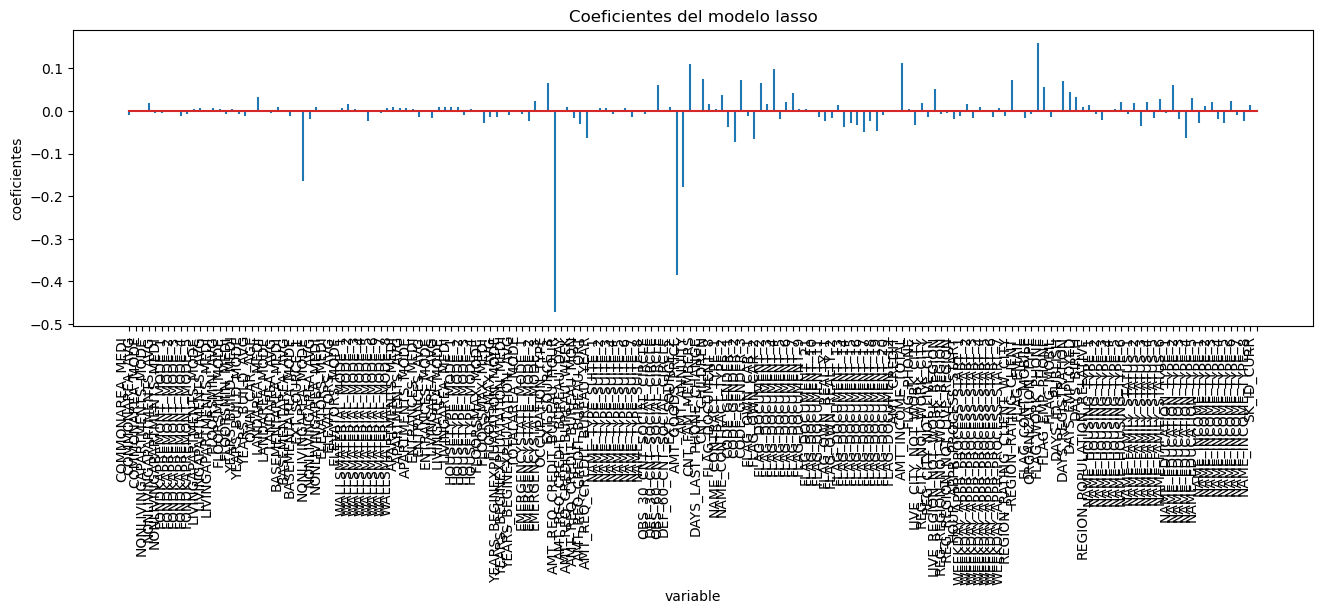

In [64]:
df_coeficientes_lasso = pd.DataFrame(
                        {'predictor': X_train_scaled.columns,
                         'coef': sel_lasso.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes_lasso.predictor, df_coeficientes_lasso.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo lasso');

Tras observar los diferentes métodos de selección de variables obtenemos para los 4 tipos utilizaos las siguientes variables:

In [25]:
rf_features = {'EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1','DAYS_BIRTH','DAYS_EMPLOYED','OCCUPATION_TYPE',
               'DAYS_LAST_PHONE_CHANGE','ORGANIZATION_TYPE','DAYS_ID_PUBLISH','AMT_GOODS_PRICE',
               'DAYS_REGISTRATION','AMT_CREDIT','AMT_ANNUITY','NAME_EDUCATION_TYPE_2'}

lightGBM_features = {"EXT_SOURCE_3","EXT_SOURCE_2","EXT_SOURCE_1","DAYS_BIRTH","DAYS_ID_PUBLISH","AMT_ANNUITY",
                     "DAYS_REGISTRATION","DAYS_EMPLOYED","AMT_CREDIT","DAYS_LAST_PHONE_CHANGE"}

ridge_features = {'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'NONLIVINGAPARTMENTS_MODE','NONLIVINGAPARTMENTS_AVG', 
                  'LIVINGAPARTMENTS_MEDI', 'YEARS_BUILD_MODE','YEARS_BUILD_AVG','LANDAREA_MEDI', 'LANDAREA_AVG', 
                  'BASEMENTAREA_AVG','BASEMENTAREA_MODE', 'EXT_SOURCE_1', 'NONLIVINGAREA_MODE','ELEVATORS_MODE', 
                  'FLOORSMAX_MODE', 'OCCUPATION_TYPE', 'EXT_SOURCE_3','AMT_REQ_CREDIT_BUREAU_QRT', 
                  'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2','AMT_GOODS_PRICE', 'AMT_ANNUITY','DAYS_LAST_PHONE_CHANGE',
                  'CODE_GENDER_1', 'CODE_GENDER_2', 'FLAG_OWN_CAR_1', 'FLAG_OWN_CAR_2','FLAG_DOCUMENT_3', 
                  'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_6','FLAG_DOCUMENT_10', 'AMT_CREDIT', 'REG_CITY_NOT_LIVE_CITY',
                  'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT','ORGANIZATION_TYPE', 'FLAG_WORK_PHONE',
                  'DAYS_ID_PUBLISH','DAYS_EMPLOYED', 'NAME_EDUCATION_TYPE_1', 'NAME_EDUCATION_TYPE_2',
                  'NAME_INCOME_TYPE_6', 'NAME_INCOME_TYPE_7'}

lasso_features = {'EXT_SOURCE_1', 'OCCUPATION_TYPE', 'EXT_SOURCE_3',
                    'AMT_REQ_CREDIT_BUREAU_QRT', 'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2',
                    'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'DAYS_LAST_PHONE_CHANGE',
                    'CODE_GENDER_1', 'CODE_GENDER_2', 'FLAG_OWN_CAR_1', 'FLAG_OWN_CAR_2',
                    'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_16', 'AMT_CREDIT',
                    'REG_CITY_NOT_LIVE_CITY', 'REGION_RATING_CLIENT_W_CITY',
                    'ORGANIZATION_TYPE', 'FLAG_WORK_PHONE', 'DAYS_ID_PUBLISH',
                    'NAME_EDUCATION_TYPE_1', 'NAME_EDUCATION_TYPE_3'}

Una vez vistas las variables para cada uno de los métodos, decido elegir las variables obtenidas en Lasso debido a que:
- RandomForest y LightGBM: 
No considero óptimo elegir ni las variables obtenidas en el RandomForest ni en el LightGBM, debido a que cada una ha dado diferentes variables por encima de la variable random_feature introducida lo que puede indicar que las variables estan sesgadas según el modelo, por lo que para otros modelos que pueda ejecutar, las variables óptimas podrían ser las mismas.
- Ridge: 
Para el coeficiente de 0.05 me parece que devuelve demasiadas varaibles, que luego no coinciden con la de los otros métodos de elección, por lo cual lo descarto
- Lasso:
Finalmente decido optar por las variables obtenidas en lasso, la gran mayoría coinciden con la de los otros métodos y me parece que 21 variables son las suficientes para poder trabajar con ellas.



In [26]:
lasso_features = ['EXT_SOURCE_1', 'OCCUPATION_TYPE', 'EXT_SOURCE_3',
                    'AMT_REQ_CREDIT_BUREAU_QRT', 'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2',
                    'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'DAYS_LAST_PHONE_CHANGE',
                    'CODE_GENDER_1', 'CODE_GENDER_2', 'FLAG_OWN_CAR_1', 'FLAG_OWN_CAR_2',
                    'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_16', 'AMT_CREDIT',
                    'REG_CITY_NOT_LIVE_CITY', 'REGION_RATING_CLIENT_W_CITY',
                    'ORGANIZATION_TYPE', 'FLAG_WORK_PHONE', 'DAYS_ID_PUBLISH',
                    'NAME_EDUCATION_TYPE_1', 'NAME_EDUCATION_TYPE_3']

# MODELIZACIÓN

Primero hemos de definir los parámetros, en este caso como hemos dicho anteriormente, utilizaremos las variables obtenidas en la regularización de Lasso.

In [27]:
X_train_scaled_filtered = X_train_scaled[lasso_features]
X_test_scaled_filtered = X_test_scaled[lasso_features]
y_train = y_train
y_test = y_test

In [28]:
X_train_scaled_filtered.head()

,EXT_SOURCE_1,OCCUPATION_TYPE,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_QRT,DEF_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE,CODE_GENDER_1,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_16,AMT_CREDIT,REG_CITY_NOT_LIVE_CITY,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,FLAG_WORK_PHONE,DAYS_ID_PUBLISH,NAME_EDUCATION_TYPE_1,NAME_EDUCATION_TYPE_3
0,0.012931,-0.737007,0.950260,-0.294248,-0.323735,1.246123,-0.727463,-0.018001,0.377622,0.719908,...,-1.564192,-0.10013,-0.782853,-0.291707,-2.053105,-1.368292,-0.500180,0.198901,0.638708,-0.567136
1,0.012931,1.162103,0.111918,0.987603,-0.323735,0.391968,-0.849342,-0.123228,1.102248,-1.389066,...,0.639308,-0.10013,-0.856292,-0.291707,1.927180,0.985387,-0.500180,-1.079590,0.638708,-0.567136
2,-0.513031,-0.737007,-2.418920,-0.294248,1.948554,0.559260,-0.179006,-0.124784,-1.347449,0.719908,...,0.639308,-0.10013,-0.012926,-0.291707,-0.062963,0.264630,-0.500180,1.906870,-1.565660,-0.567136
3,0.268820,0.715513,1.081943,-0.294248,-0.323735,0.733992,0.369450,0.380491,0.690941,0.719908,...,0.639308,-0.10013,0.188033,-0.291707,-0.062963,0.985387,-0.500180,-0.585823,0.638708,-0.567136
4,-1.082039,0.715513,0.728806,0.987603,-0.323735,-1.098058,-1.056537,-0.956324,-1.609960,0.719908,...,-1.564192,-0.10013,-1.071463,-0.291707,1.927180,0.629004,1.999279,-0.207379,0.638708,-0.567136


# MODELO BASE: Dummy

In [30]:
from sklearn.dummy import DummyClassifier

In [31]:
base_model = DummyClassifier(strategy="most_frequent")
base_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_base = base_model.predict(X_test_scaled)

# Evaluación
print("Precisión del modelo base:", accuracy_score(y_test, y_pred_base))

Precisión del modelo base: 0.9192722306228964


In [32]:
base_model = DummyClassifier(strategy="most_frequent")
base_model.fit(X_train_scaled_filtered, y_train)

# Predicciones
y_pred_base = base_model.predict(X_test_scaled_filtered)

# Evaluación
print("Precisión del modelo base:", accuracy_score(y_test, y_pred_base))

Precisión del modelo base: 0.9192722306228964


El docente, Diego Bodas, nos recomendó aplicar los modelos a todas las variables y luego a nuestras variables seleccionadas ya que, aparentemente, había dos variables que estaban explicando casi los modelos en su totalidad, siendo estas EXT_SOURCE_3 y EXT_SOURCE_2, por lo que, y no solo el modelo básico anterior, voy a realizar los modelos para las variables filtradas por la regularización Lasso y también con todas las variables del dataset a ver si hay una gran diferencia. De momento con el modelo básico vemos que los resultados son los mismos.

# MODELOS MÁS AVANZADOS
He optado por, además de los modelos obligatorios (RandomForest y XGBoost), modelos que sean interesantes de cara a un problema de clasificación como es este, el cual es desbalanceado y se considera que el dataset es bastante grande como para aplicar modelos sencillos como el KNeighbors. Como ya he mencionado anteriormente, aplicaré los modelos al conjunto en su totalidad y a las variables obtenidas por la regularización Lasso.

También mencionar que la métrica en la que nos vamos a centrar para este problema es el "Recall" o "Sensitividad" ya que es una métrica muy importante para problemas desbalanceados y grandes, como es el caso, y en el que además la clase minoritaria (1 = "Tuvieron dificultades a la hora de realizar pagos") es un aspecto crucial que no se puede pasar por alto y buscaré minimizar el error para esta clase.

De esta manera, es posible que perdamos un poco de efectividad en la clase 0 = "No tuvieron dificultades" y que algunos puedan ser clasificados como que si tuvieron dificultades, pero en este problema opino que es más crítico que clasifique a los que si tuvieron como que no tuvieron dificultades.

In [43]:
classifiers = [
    RandomForestClassifier(class_weight='balanced', random_state=seed),
    XGBClassifier(scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]), random_state=seed, eval_metric='logloss'),
    LGBMClassifier(is_unbalance=True, random_state=seed),
    AdaBoostClassifier(random_state=seed),
    LogisticRegression(class_weight='balanced', random_state=seed, solver='liblinear'),
    CatBoostClassifier(iterations=300, depth=10, learning_rate=0.1, cat_features=[], random_state=seed, verbose=0),
    DecisionTreeClassifier(class_weight='balanced', random_state=seed),
    HistGradientBoostingClassifier(random_state=seed),
    ExtraTreesClassifier(class_weight='balanced', random_state=seed),
    SGDClassifier(loss='hinge', class_weight='balanced', random_state=seed, max_iter=1000)
]

# Evaluar cada clasificador
for classifier in classifiers:
    print(f"Evaluando modelo: {classifier.__class__.__name__}")
    
    # Predecir con validación cruzada para obtener resultados más robustos
    y_pred = cross_val_predict(classifier, X_train_scaled, y_train, cv=5, method="predict")
    
    # Calcular métricas
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print("-" * 40)

Evaluando modelo: RandomForestClassifier
Recall: 0.002
F1-Score: 0.004
----------------------------------------
Evaluando modelo: XGBClassifier
Recall: 0.599
F1-Score: 0.272
----------------------------------------
Evaluando modelo: LGBMClassifier
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.195629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11475
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 165
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.166107 seconds.
You can set `f

c:\Users\pablo\anaconda3\envs\practica_EDA\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\pablo\anaconda3\envs\practica_EDA\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\pablo\anaconda3\envs\practica_EDA\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\pablo\anaconda3\envs\practica_EDA\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

Recall: 0.020
F1-Score: 0.039
----------------------------------------
Evaluando modelo: LogisticRegression
Recall: 0.677
F1-Score: 0.260
----------------------------------------
Evaluando modelo: CatBoostClassifier
Recall: 0.022
F1-Score: 0.043
----------------------------------------
Evaluando modelo: DecisionTreeClassifier
Recall: 0.155
F1-Score: 0.149
----------------------------------------
Evaluando modelo: HistGradientBoostingClassifier
Recall: 0.015
F1-Score: 0.030
----------------------------------------
Evaluando modelo: ExtraTreesClassifier
Recall: 0.001
F1-Score: 0.001
----------------------------------------
Evaluando modelo: SGDClassifier
Recall: 0.644
F1-Score: 0.237
----------------------------------------


**A posteriorí he realizado un análisis con solo las variables obtenidas en la regularización de Lasso, y he obtenido más o menos los mismos resultados, por lo que a partir de este punto trabajo con solo esas variables.**

A continuación, defino una función que me va a en una misma linea de gráficos el gráfico de la matriz de confusión y la matriz de confusiopn normalizada. Esto me ayudará a representar y visualizar de forma más sencilla ambas matrices en una misma linea de 2 gráficos

In [37]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', figsize=(20,6)):
    """
    ----------------------------------------------------------------------------------------------------------
    Function: plot_confusion_matrix
    ----------------------------------------------------------------------------------------------------------
    - Description:
        This function plots the confusion matrix based on actual and predicted values of the target variable,
        both in absolute values and in its normalized form.
    - Inputs:
        - y_true: Array/Series with the actual values of the target variable (e.g., y_test or y_val).
        - y_pred: Array/Series with the predicted values by the model.
        - title: Title for the plot.
        - figsize: Tuple specifying the desired size for the combined plots.
    """    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ConfusionMatrixDisplay(confusion_matrix).from_predictions(y_true, y_pred, cmap='Blues', values_format=',.0f', ax=ax1)
    ConfusionMatrixDisplay(confusion_matrix).from_predictions(y_true, y_pred, cmap='Blues', normalize='true', values_format='.2%', ax=ax2)
    ax1.set_title(f'{title}', fontdict={'fontsize':18})
    ax2.set_title(f'{title} - Normalized', fontdict={'fontsize':18})
    ax1.set_xlabel('Predicted Label', fontdict={'fontsize':15})
    ax2.set_xlabel('Predicted Label', fontdict={'fontsize':15})
    ax1.set_ylabel('True Label', fontdict={'fontsize':15})
    ax2.set_ylabel('True Label', fontdict={'fontsize':15})

    plt.show()

**Una vez definida la función, voy a realizar el estudio de los diferentes modelos que voy a proponer, un total de 10, los cuales he considerado los más interesantes, además de los propuestos por el docente, para el problema al que nos enfrentabamos.**


Classifier: RandomForestClassifier(class_weight='balanced', random_state=1441)
Model Score: 0.919

    Accuracy: 0.91927
    Balanced Accuracy: 0.50266
    F2 Score: 0.00728
    F1 Score: 0.01155
    Precision: 0.50000
    Recall: 0.00584
    


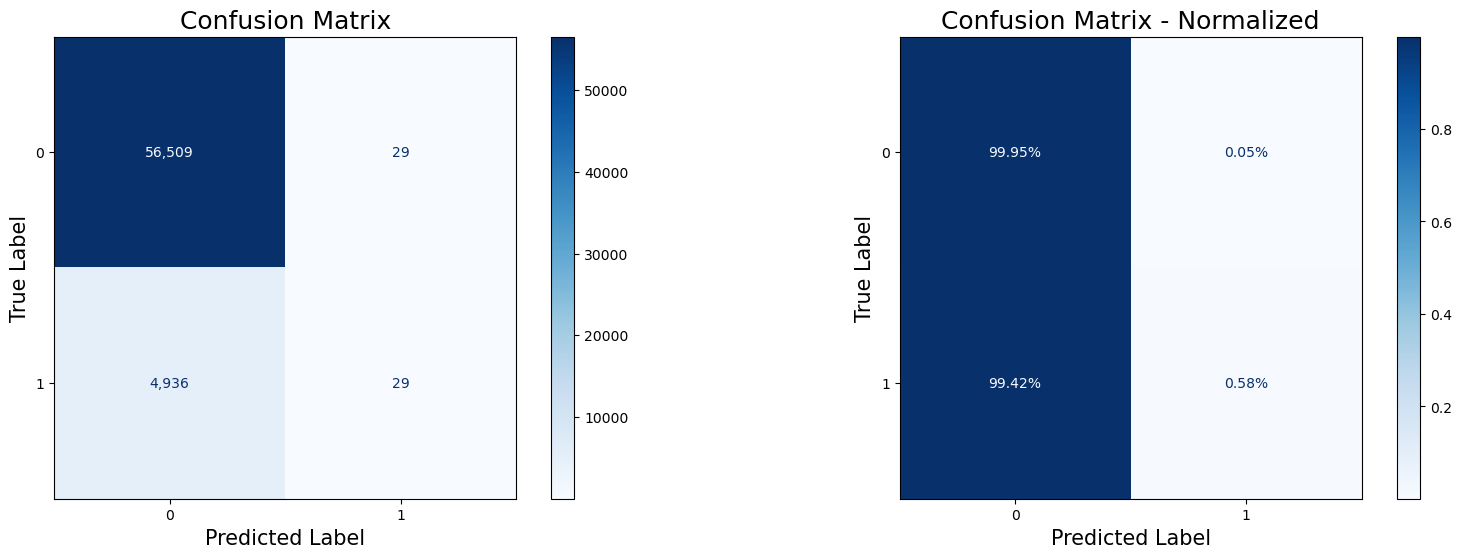

-----------------------------------------------

Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=1441, ...)
Model Score: 0.723

    Accuracy: 0.72314
    Balanced Accuracy: 0.68048
    F2 Score: 0.40943
    F1 Score: 0.26856
    Precision: 0.17068
    Recall: 0.62961
    


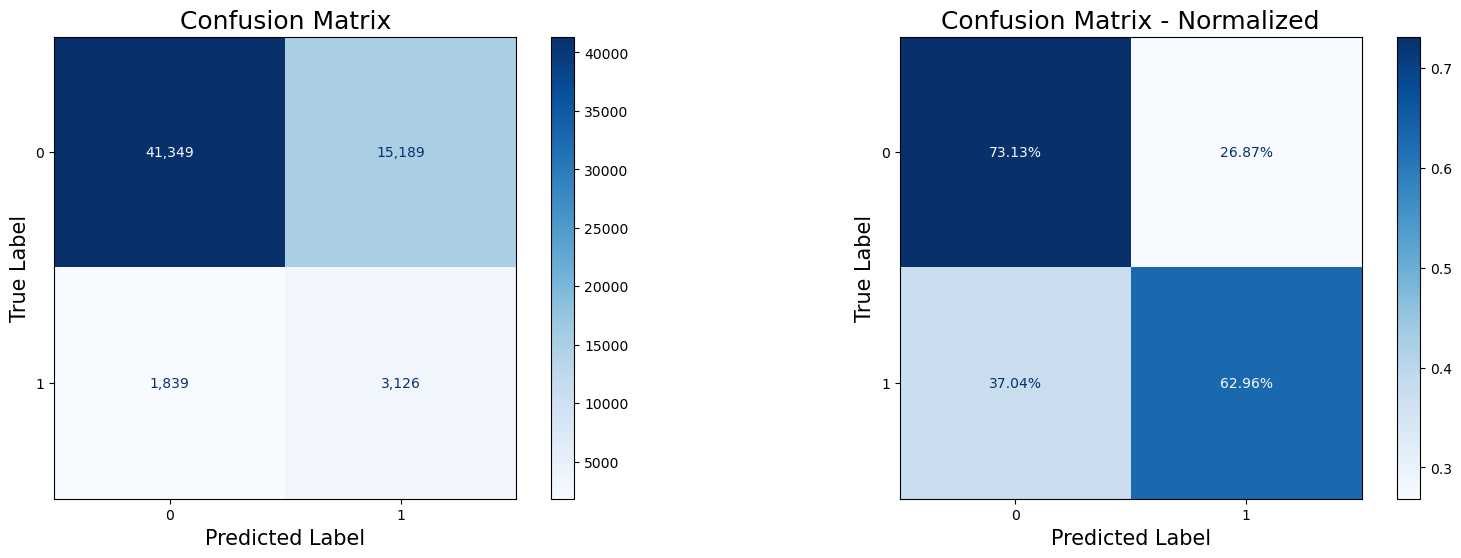

-----------------------------------------------
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2170
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482

Classifier: LGBMClassifier(is_unbalance=True, random_state=1441)
Model Score: 0.694

    Accuracy: 0.69380
    Balanced Accuracy: 0.69190
    F2 Score: 0.42193
    F1 Score: 0.26667
    Precision: 0.16529
    Recall: 0.68963
    


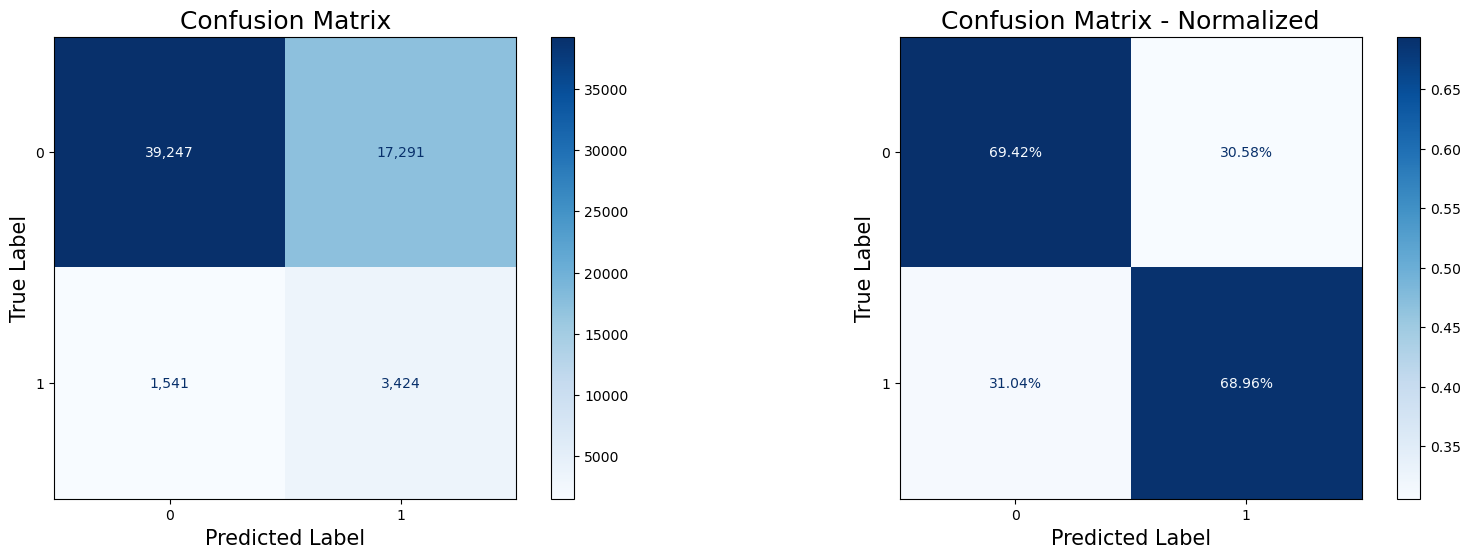

-----------------------------------------------


c:\Users\pablo\anaconda3\envs\practica_EDA\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Classifier: AdaBoostClassifier(random_state=1441)
Model Score: 0.919

    Accuracy: 0.91921
    Balanced Accuracy: 0.50786
    F2 Score: 0.02146
    F1 Score: 0.03346
    Precision: 0.48864
    Recall: 0.01732
    


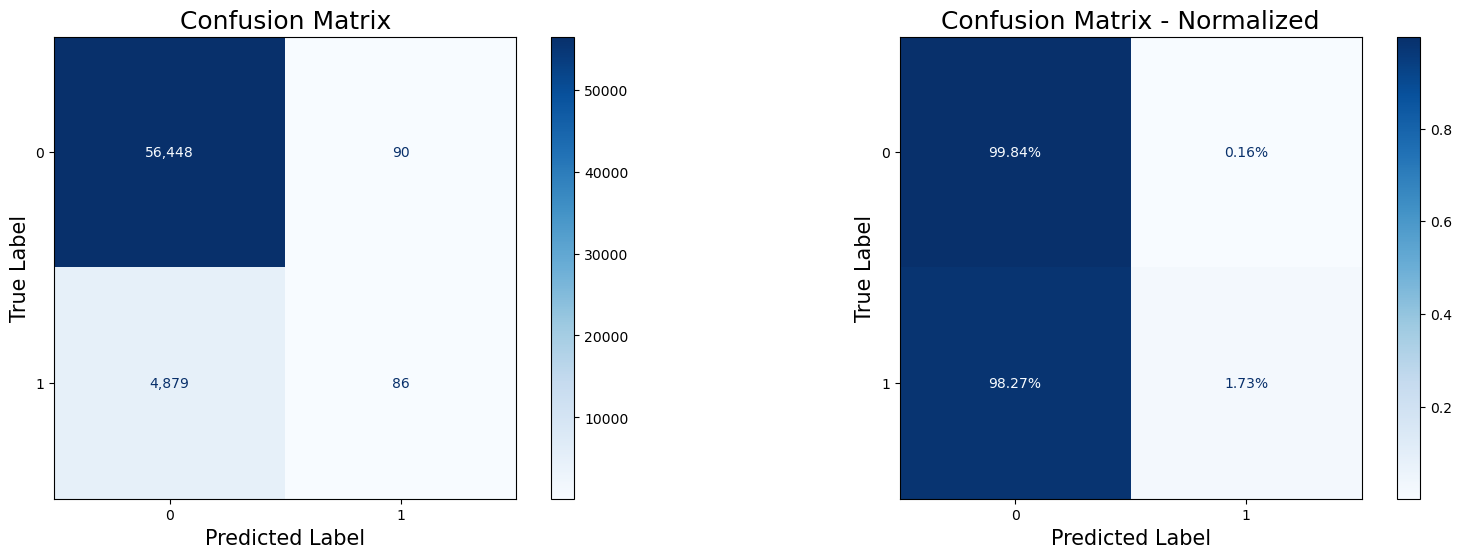

-----------------------------------------------

Classifier: LogisticRegression(class_weight='balanced', random_state=1441,
                   solver='liblinear')
Model Score: 0.686

    Accuracy: 0.68553
    Balanced Accuracy: 0.68326
    F2 Score: 0.41213
    F1 Score: 0.25894
    Precision: 0.15988
    Recall: 0.68056
    


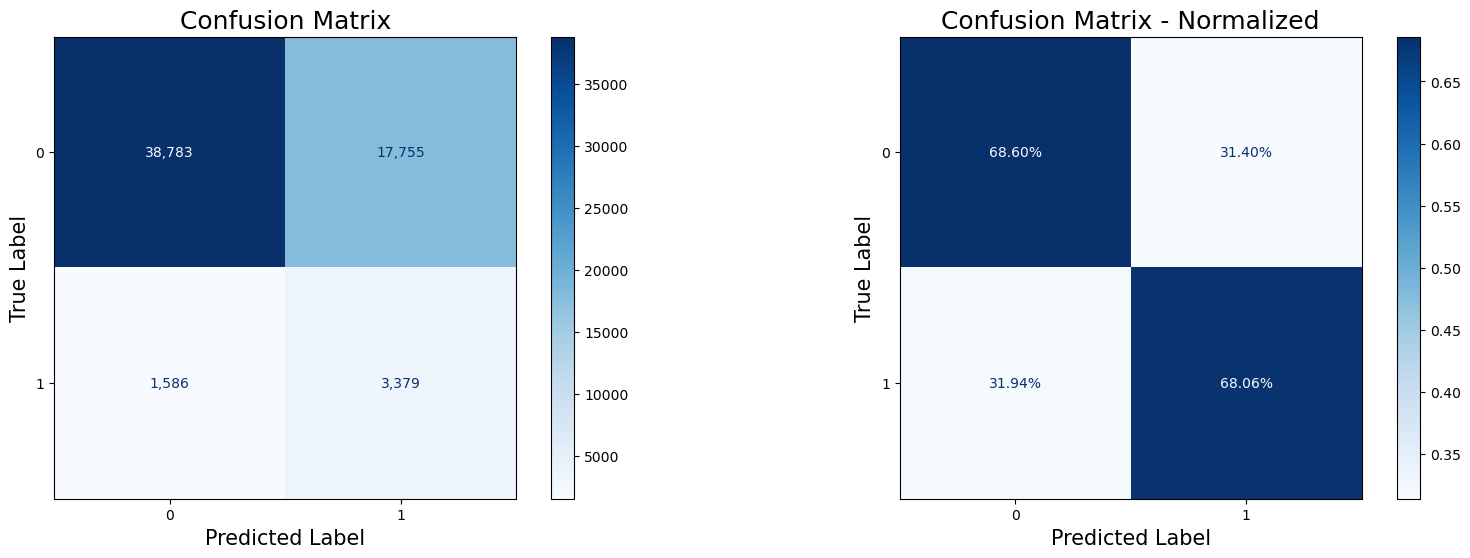

-----------------------------------------------

Classifier: <catboost.core.CatBoostClassifier object at 0x00000250DA218910>
Model Score: 0.919

    Accuracy: 0.91935
    Balanced Accuracy: 0.51144
    F2 Score: 0.03084
    F1 Score: 0.04762
    Precision: 0.51029
    Recall: 0.02497
    


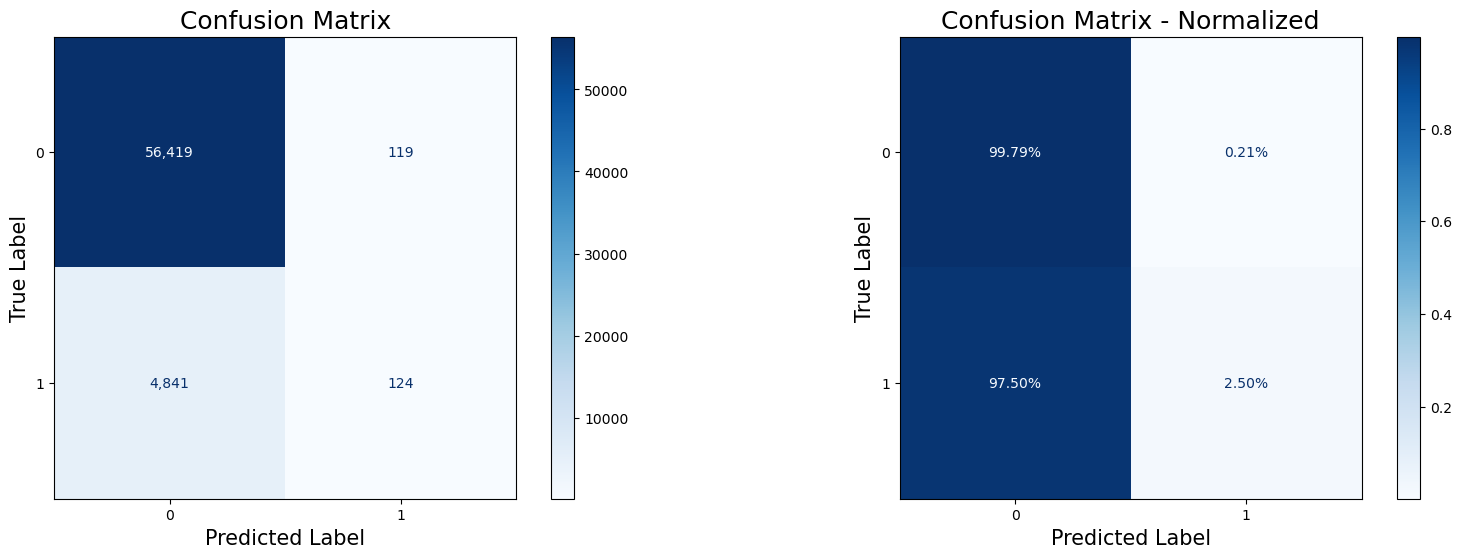

-----------------------------------------------

Classifier: DecisionTreeClassifier(class_weight='balanced', random_state=1441)
Model Score: 0.861

    Accuracy: 0.86129
    Balanced Accuracy: 0.53644
    F2 Score: 0.14856
    F1 Score: 0.14784
    Precision: 0.14665
    Recall: 0.14904
    


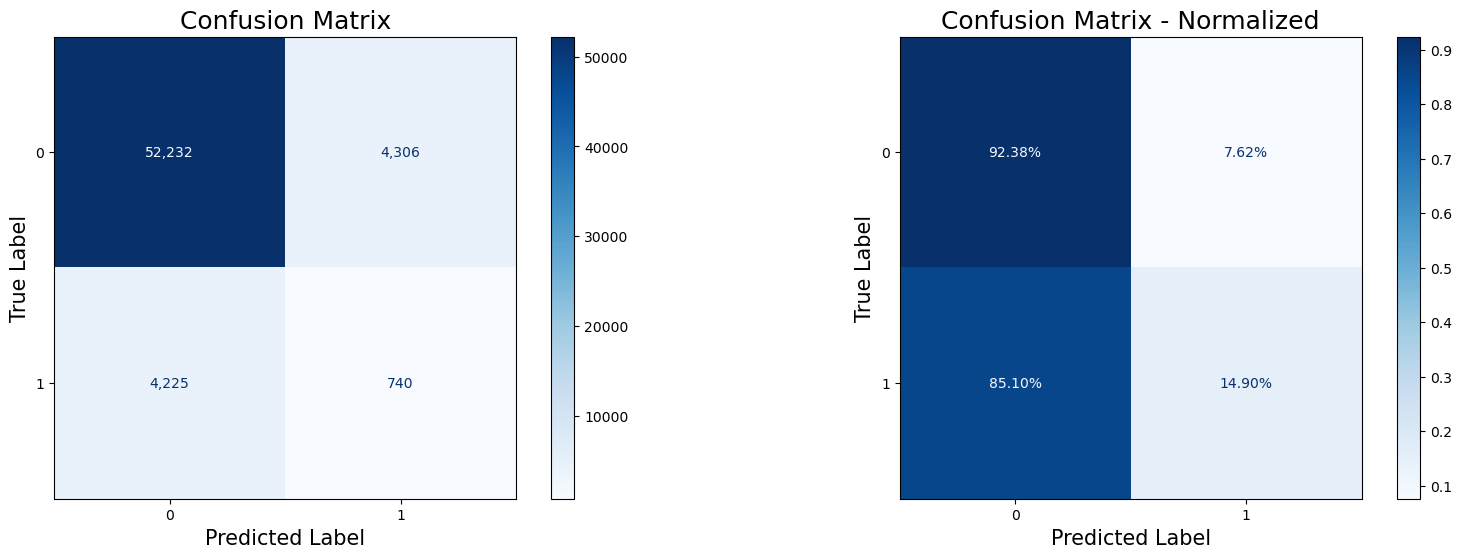

-----------------------------------------------

Classifier: HistGradientBoostingClassifier(random_state=1441)
Model Score: 0.919

    Accuracy: 0.91947
    Balanced Accuracy: 0.50617
    F2 Score: 0.01652
    F1 Score: 0.02596
    Precision: 0.55000
    Recall: 0.01329
    


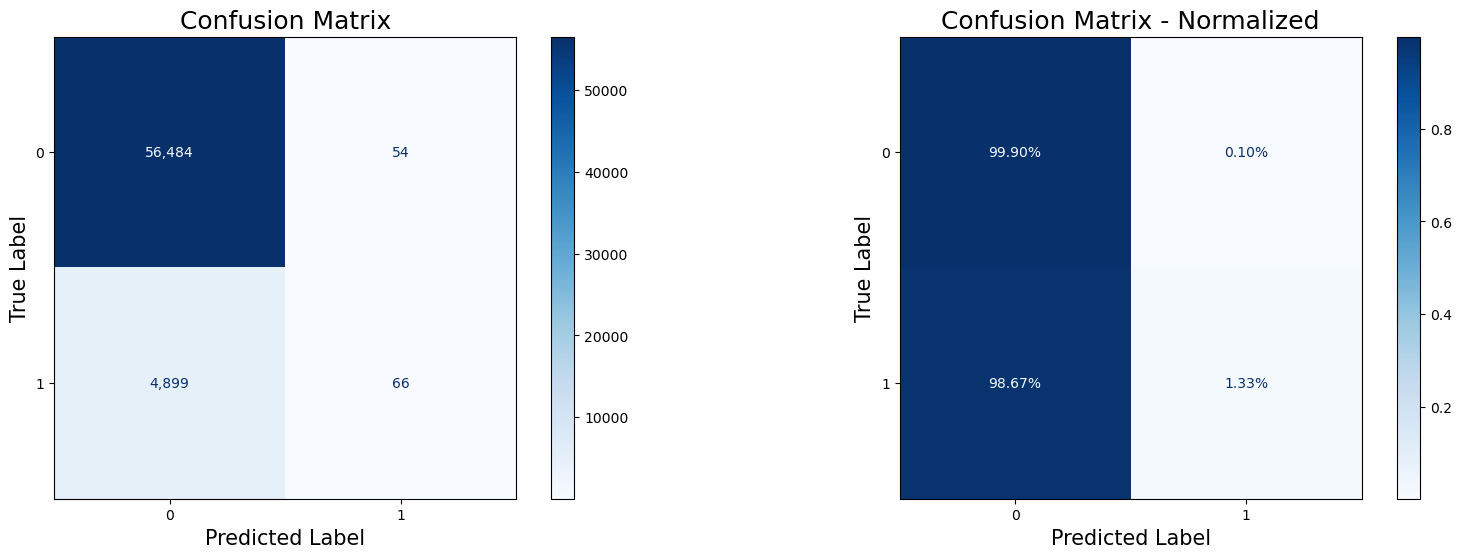

-----------------------------------------------

Classifier: ExtraTreesClassifier(class_weight='balanced', random_state=1441)
Model Score: 0.919

    Accuracy: 0.91919
    Balanced Accuracy: 0.50308
    F2 Score: 0.00853
    F1 Score: 0.01350
    Precision: 0.46575
    Recall: 0.00685
    


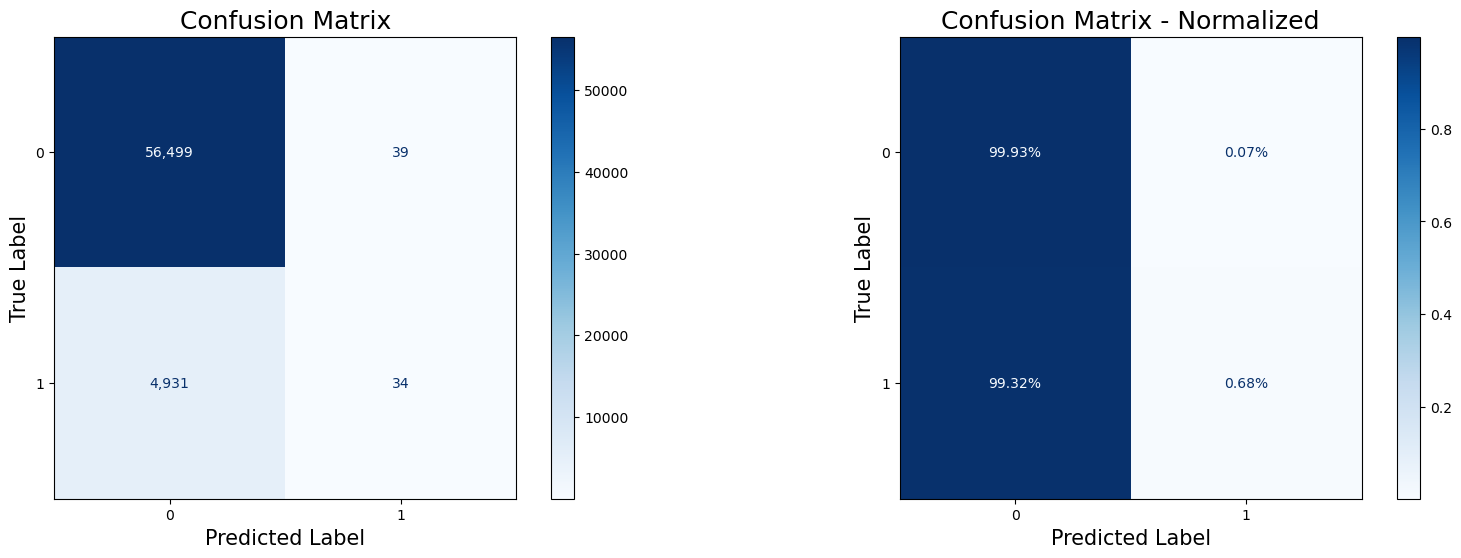

-----------------------------------------------

Classifier: SGDClassifier(class_weight='balanced', random_state=1441)
Model Score: 0.692

    Accuracy: 0.69236
    Balanced Accuracy: 0.67219
    F2 Score: 0.39973
    F1 Score: 0.25382
    Precision: 0.15781
    Recall: 0.64814
    


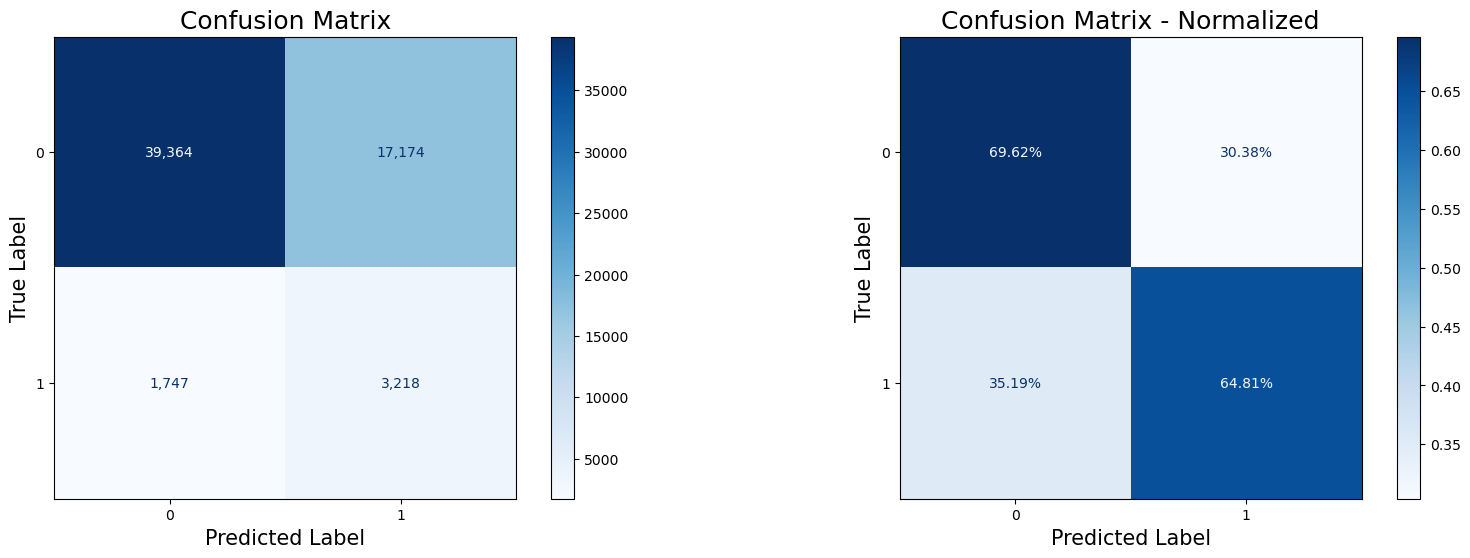

-----------------------------------------------


In [38]:
# Lista de clasificadores
classifiers = [
    RandomForestClassifier(class_weight='balanced', random_state=seed),
    XGBClassifier(scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]), random_state=seed, eval_metric='logloss'),
    LGBMClassifier(is_unbalance=True, random_state=seed),
    AdaBoostClassifier(random_state=seed),
    LogisticRegression(class_weight='balanced', random_state=seed, solver='liblinear'),
    CatBoostClassifier(iterations=300, depth=10, learning_rate=0.1, cat_features=[], random_state=seed, verbose=0),
    DecisionTreeClassifier(class_weight='balanced', random_state=seed),
    HistGradientBoostingClassifier(random_state=seed),
    ExtraTreesClassifier(class_weight='balanced', random_state=seed),
    SGDClassifier(loss='hinge', class_weight='balanced', random_state=seed, max_iter=1000)
]

# Bucle para entrenar, predecir y calcular métricas para cada clasificador
for classifier in classifiers:
    # Crear pipeline con el clasificador actual
    pipe = Pipeline(steps=[('classifier', classifier)])
    
    # Entrenar el modelo
    pipe.fit(X_train_scaled_filtered, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = pipe.predict(X_test_scaled_filtered)
    y_true = y_test  # Variable para mayor claridad
    
    # Mostrar resultados
    print(f"\nClassifier: {classifier}")
    print(f"Model Score: {pipe.score(X_test_scaled_filtered, y_test):.3f}")
    print(f'''
    Accuracy: {accuracy_score(y_true, y_pred):.5f}
    Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.5f}
    F2 Score: {fbeta_score(y_true, y_pred, beta=2):.5f}
    F1 Score: {f1_score(y_true, y_pred):.5f}
    Precision: {precision_score(y_true, y_pred):.5f}
    Recall: {recall_score(y_true, y_pred):.5f}
    ''')
    plot_confusion_matrix(y_true, y_pred)
    
    print("-----------------------------------------------")

**En cuanto a los modelos estudiados,viendo los resultados anteriores y siendo nuestro objetivo el de detectar positivos y maximizar el F2 Score me he quedado con los siguientes modelos para estudiar más a fondo:**

- Primera opción: LGBMClassifier. Combina el mejor Recall (0.68963) con un F2 Score competitivo (0.42193). Además, es eficiente en datasets grandes.

- Segunda opción: XGBClassifier. Similar a LGBM, pero con un Recall ligeramente menor (0.62961).

- LogisticRegression como modelo baseline para comparación.

**Y adicionalmente, a petición del docente:**

- RandomForestClassifier


**A continuación, realizo un undersampling de los modelos seleccionados.**

¿Por qué Undersampling?

La técnica de undersampling me parece más eficiente y adecuada para una problemática como la de pagos e impagos, ya que no implica la creación de datos artificiales. En un contexto real, el oversampling podría generar dudas, ya que consiste en añadir muestras sintéticas que no existen en el dataset original. Esto puede ser difícil de justificar frente a un cliente, especialmente si se cuestiona la validez de los resultados al aplicarlos a los datos reales disponibles. Por tanto, el undersampling no solo resulta más transparente, sino también más alineado con los datos reales del cliente, lo que facilita la explicación y la confianza en el modelo.


Classifier: RandomForestClassifier(class_weight='balanced', random_state=1441)
Model Score: 0.688

    Accuracy: 0.68810
    Balanced Accuracy: 0.68273
    F2 Score: 0.41158
    F1 Score: 0.25932
    Precision: 0.16041
    Recall: 0.67633
    


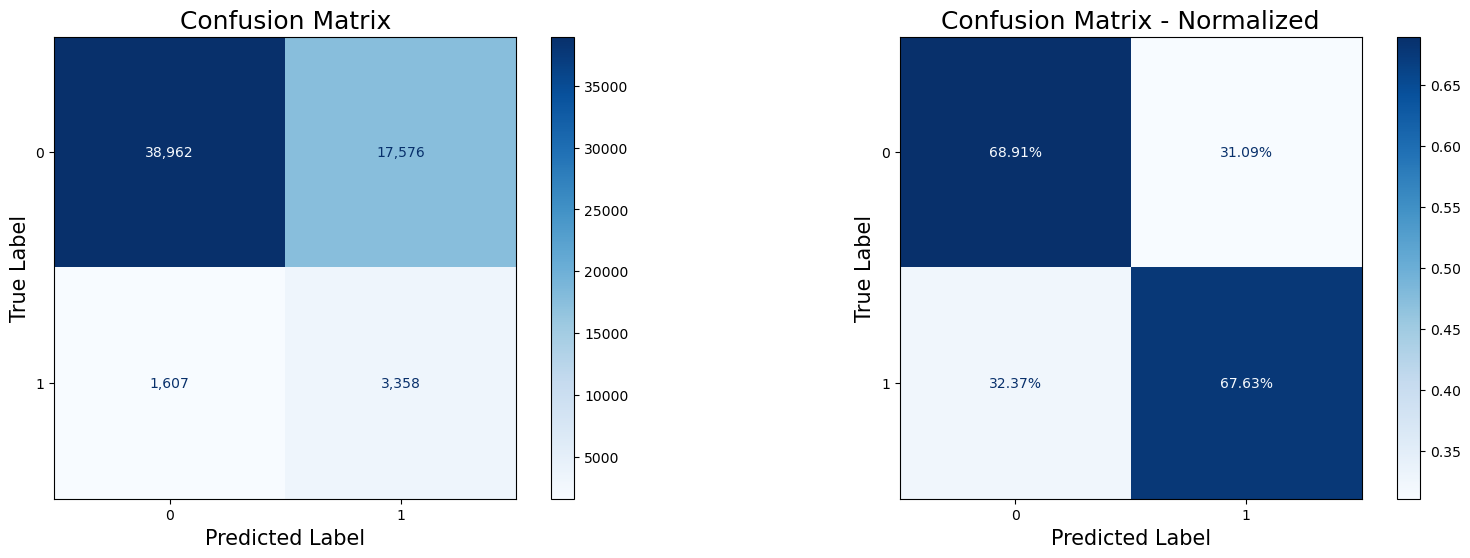

-----------------------------------------------

Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=1441, ...)
Model Score: 0.206

    Accuracy: 0.20636
    Balanced Accuracy: 0.55171
    F2 Score: 0.32645
    F1 Score: 0.16389
    Precision: 0.08956
    Recall: 0.96354
    


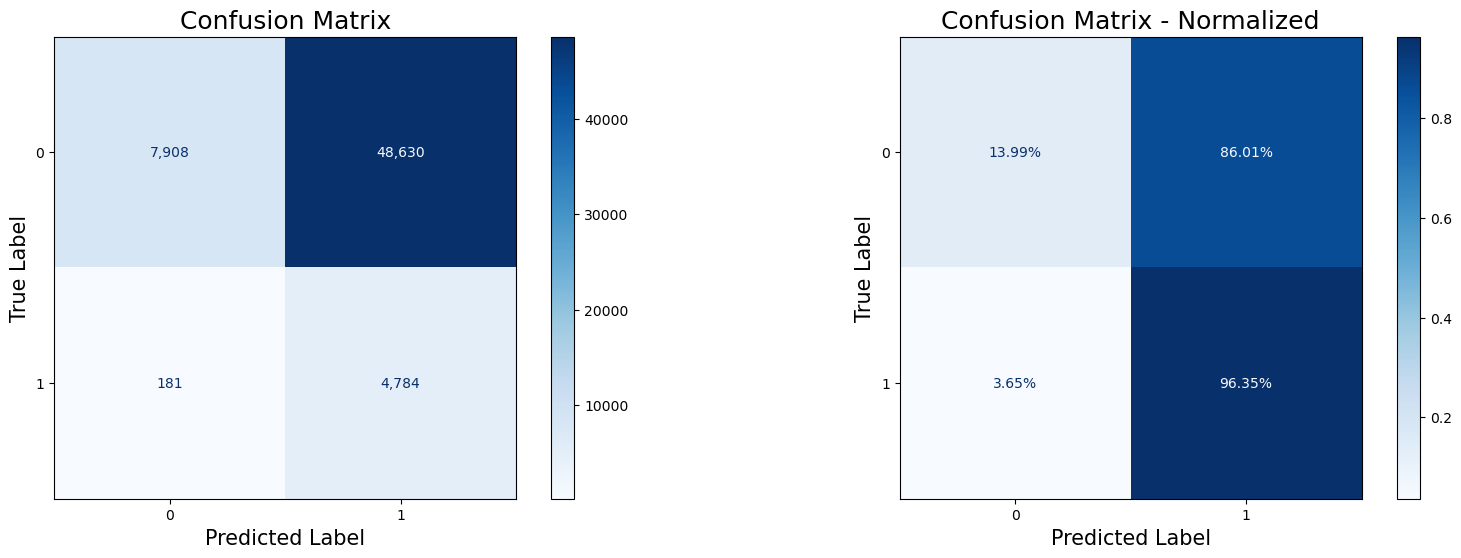

-----------------------------------------------
[LightGBM] [Info] Number of positive: 19860, number of negative: 19860
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Classifier: LGBMClassifier(is_unbalance=True, random_state=1441)
Model Score: 0.688

    Accuracy: 0.68831
    Balanced Accuracy: 0.69268
    F2 Score: 0.42261
    F1 Score: 0.26552
    Precision: 0.16395
    Recall: 0.69789
    


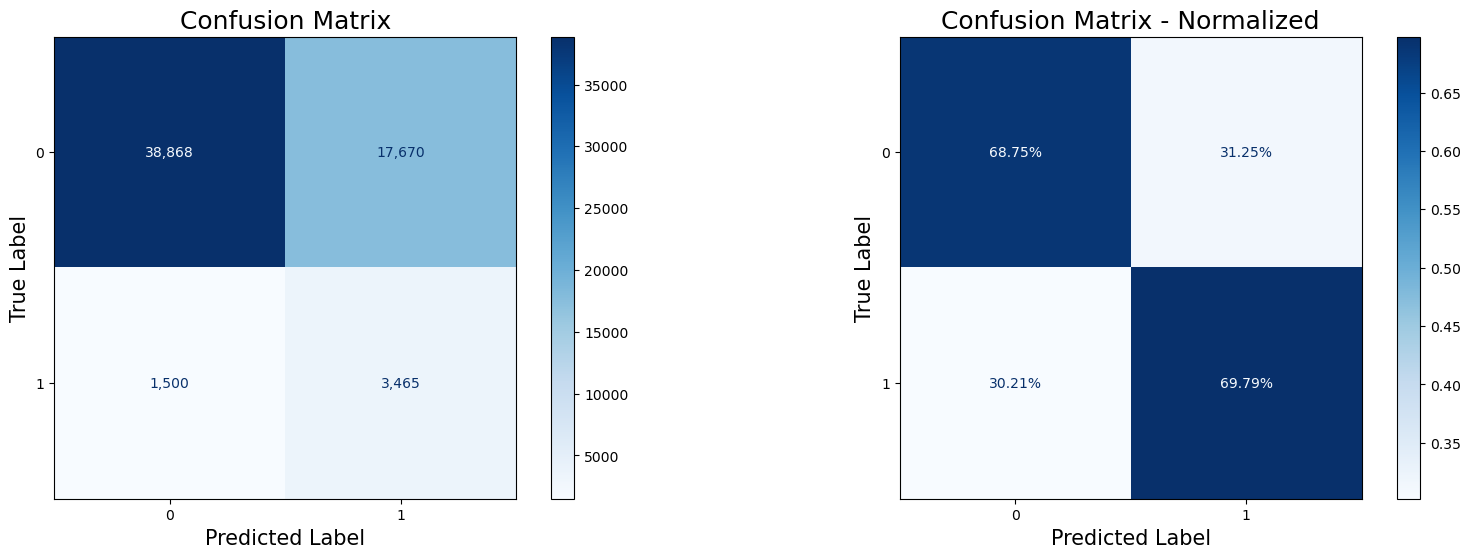

-----------------------------------------------

Classifier: LogisticRegression(class_weight='balanced', random_state=1441,
                   solver='liblinear')
Model Score: 0.684

    Accuracy: 0.68377
    Balanced Accuracy: 0.68212
    F2 Score: 0.41085
    F1 Score: 0.25776
    Precision: 0.15901
    Recall: 0.68016
    


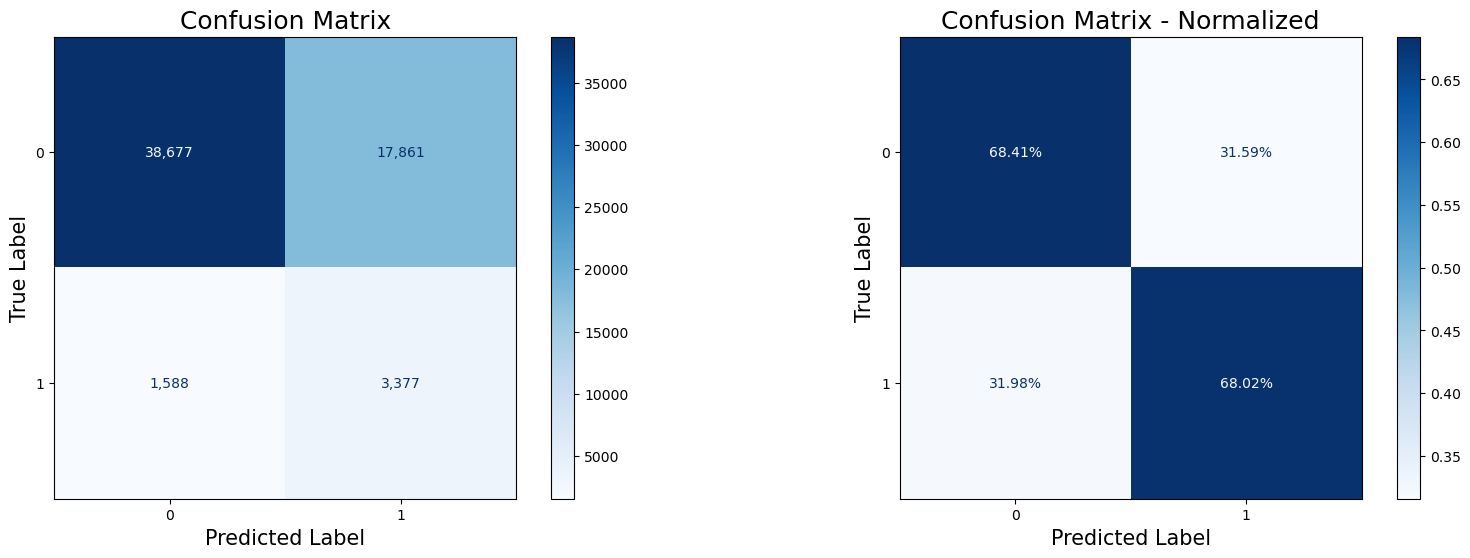

-----------------------------------------------


In [42]:
classifiers = [
    RandomForestClassifier(class_weight='balanced', random_state=seed),
    XGBClassifier(scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]), random_state=seed, eval_metric='logloss'),
    LGBMClassifier(is_unbalance=True, random_state=seed),
    LogisticRegression(class_weight='balanced', random_state=seed, solver='liblinear'),
]

# Instancia del RandomUnderSampler
rus = RandomUnderSampler(random_state=seed)

# Aplicar RandomUnderSampler y entrenar cada clasificador
for classifier in classifiers:
    # Aplicar el muestreo a los datos de entrenamiento
    X_resampled, y_resampled = rus.fit_resample(X_train_scaled_filtered, y_train)
    
    # Entrenar el modelo
    classifier.fit(X_resampled, y_resampled)
    
    # Predecir en el conjunto de prueba
    y_pred = classifier.predict(X_test_scaled_filtered)
    y_true = y_test  # Variable para mayor claridad
    
    # Mostrar resultados
    print(f"\nClassifier: {classifier}")
    print(f"Model Score: {classifier.score(X_test_scaled_filtered, y_test):.3f}")
    print(f'''
    Accuracy: {accuracy_score(y_true, y_pred):.5f}
    Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.5f}
    F2 Score: {fbeta_score(y_true, y_pred, beta=2):.5f}
    F1 Score: {f1_score(y_true, y_pred):.5f}
    Precision: {precision_score(y_true, y_pred):.5f}
    Recall: {recall_score(y_true, y_pred):.5f}
    ''')
    plot_confusion_matrix(y_true, y_pred)
    
    print("-----------------------------------------------")

Tras ver los diferentes resultados con un undersampling, la elección final es la de escoger un LightGBM, el cual es el modelo que mejores métricas tiene, en cuanto a las métricas que me interesan:
- F2 Score: 0.42261 (el más alto de los 4).
- Recall: 0.69789 (el más alto de los 4).
- Balanced Accuracy: 0.69268.

Una vez realizado esto, toca estudiar los hiperparámetros que mejor funcionen para el modelo.

In [68]:
model = LGBMClassifier(is_unbalance=True, random_state=1441)

# Rango de hiperparámetros
param_dist = {
    'num_leaves': [10], #30, 20]
    'max_depth': [5], #, 7, 10],
    'learning_rate': [0.01], #, 0.05, 0.1],
    'n_estimators': [100], # 200, 300],
    'min_child_samples': [30], #20, 50],
    'min_split_gain': [0.0], #, 0.1],
    'subsample': [0.8], #,1.0]
    'colsample_bytree': [1.0], #0.8]
    'lambda_l1': [0.5], #, 0.1],
    'lambda_l2': [0.1] #0.5]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    scoring='recall',  
    n_iter=50,     
    cv=3,
    random_state=seed,
    verbose=2,
    n_jobs=-1
)

Mejores hiperparámetros: {'subsample': 0.8, 'num_leaves': 10, 'n_estimators': 100, 'min_split_gain': 0.0, 'min_child_samples': 30, 'max_depth': 5, 
                          'learning_rate': 0.1, 'lambda_l2': 0.1, 'lambda_l1': 0.5, 'colsample_bytree': 1.0}



Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2170
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] 

In [69]:
best_model = random_search.best_estimator_

# Hacer predicciones en el conjunto de test
predictions = best_model.predict(X_test_scaled_filtered)

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


In [70]:
print("Classification Report")
print(classification_report(y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56538
           1       0.16      0.69      0.26      4965

    accuracy                           0.68     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.68      0.76     61503



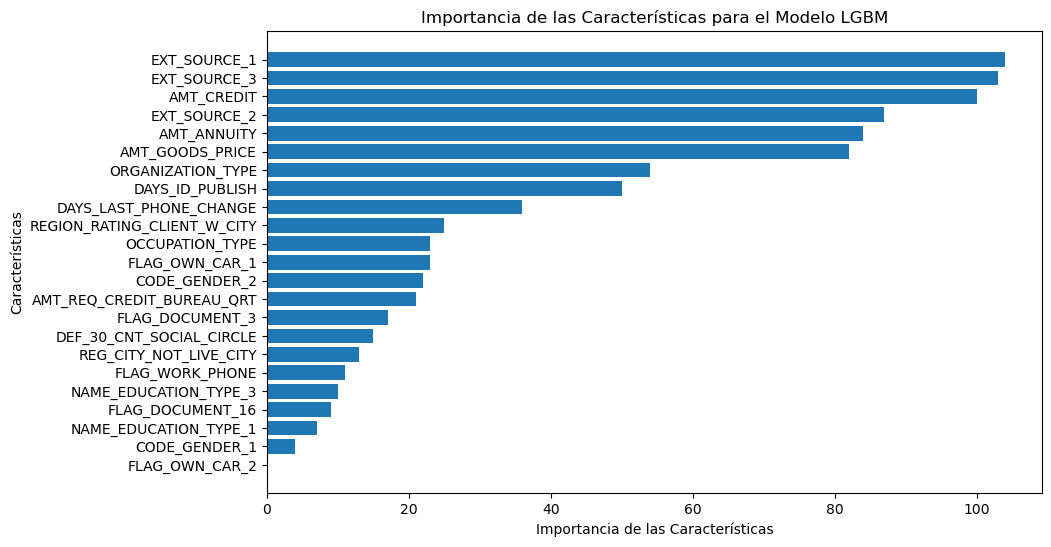

In [71]:
feature_importances = best_model.feature_importances_

# Ordenar las características según su importancia en orden ascendente
indices = feature_importances.argsort()  # Ordena en orden ascendente

sorted_feature_importances = feature_importances[indices]
sorted_feature_names = X_train_scaled_filtered.columns[indices]

# Visualizar la importancia de las características ordenadas
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances)
plt.xlabel('Importancia de las Características')
plt.ylabel('Características')
plt.title('Importancia de las Características para el Modelo LGBM')
plt.show()

Nos encontramos como las importancias de las variables ha cambiado, antes encontrabamos que las dos variables que más explicaban el modelo eran EXT_SOURCE_3 y EXT_SOURCE_2, ahora ha cambiado el orden de importancia e incluso se ve como una variable, AMT_CREDIT, que antes tenía un peso inferior ahora parece explicar más del modelo en cuestión.

In [73]:
recall_score(y_test, predictions)

0.6944612286002014

El modelo LightGBM ha mostrado un rendimiento aceptable con un recall de aproximadamente 0.7, lo cual es prometedor en un problema de clasificación con clases altamente desbalanceadas (proporción 92/8). Este buen desempeño en el recall es un indicio de que el modelo es capaz de identificar correctamente una buena parte de las instancias de la clase minoritaria (clase 1).

Sin embargo, es importante notar que el rendimiento del modelo debe ser evaluado con más métricas para obtener una visión completa. Las métricas adicionales, como la precisión, el F1-score y la curva ROC, proporcionarán una evaluación más holística del modelo.

In [74]:
precision_score(y_test, predictions)

0.16121943236545566

Al ser un problema claramente desbalanceado se afecta a métricas como el accuracy o precision, el cual es de 0.16.  La precisión y la exactitud son bajas lo que indica que el modelo tiene dificultades para identificar correctamente las instancias de la clase minoritaria. Esto es esperado en problemas desbalanceados, donde la predicción errónea tiende a ser la clase mayoritaria.

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Confusion matrix, without normalization
[[38599 17939]
 [ 1517  3448]]
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Normalized confusion matrix
[[0.68270897 0.31729103]
 [0.30553877 0.69446123]]


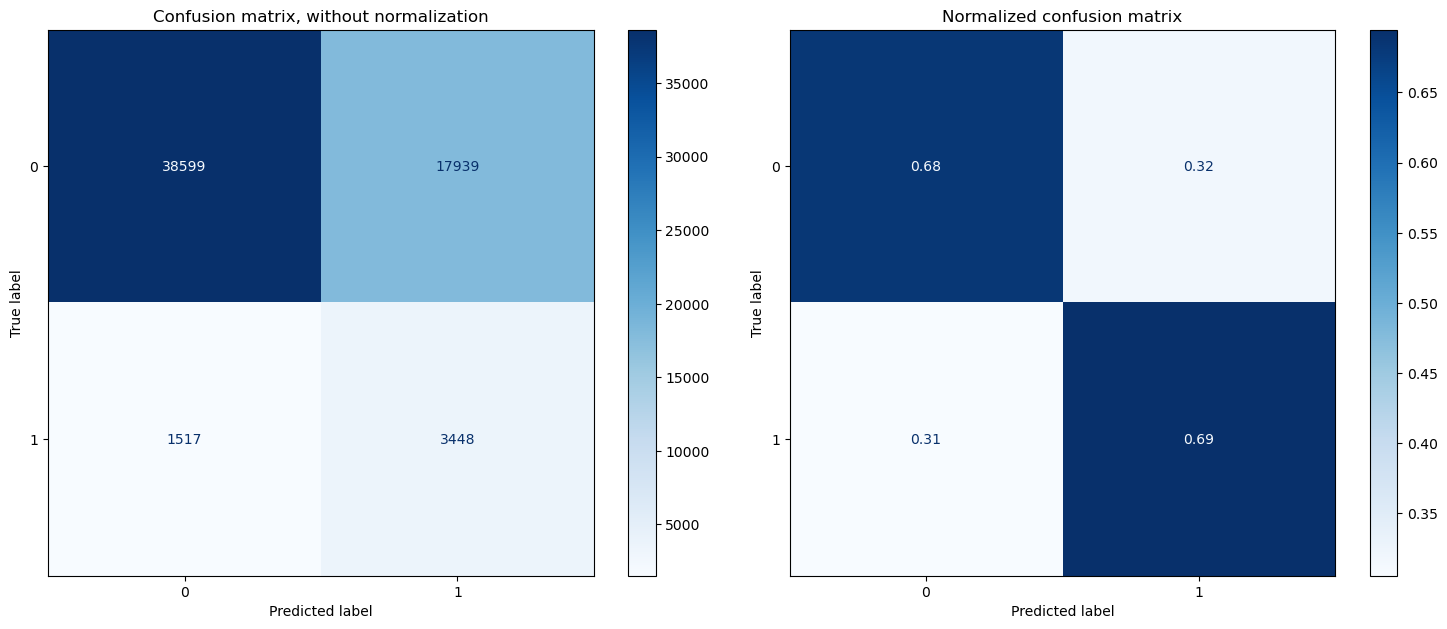

In [91]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

# Crear figura de múltiples subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Itera sobre los diferentes tipos de matrices de confusión
for idx, (title, normalize) in enumerate(titles_options):
    # Calcula la matriz de confusión
    cm = confusion_matrix(y_test, best_model.predict(X_test_scaled_filtered))

    # Si 'normalize' es 'true', normaliza la matriz de confusión
    if normalize == 'true':
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Crea el gráfico de la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    # Dibuja la matriz de confusión en el eje correspondiente
    disp.plot(cmap=plt.cm.Blues, ax=axes[idx])
    
    # Establece el título
    axes[idx].set_title(title)
    
    # Muestra la matriz de confusión
    print(title)
    print(cm)

# Muestra la figura completa
plt.tight_layout()
plt.show()

Aunque la matriz normalizada muestra un buen manejo de la clase 1 en términos de precisión, los errores fuera de la diagonal reflejan que el modelo sigue teniendo dificultades en clasificar correctamente las instancias de la clase minoritaria.

Esto podría indicar que aunque el modelo es relativamente efectivo para la clase mayoritaria, todavía presenta limitaciones en problemas de clasificación desbalanceada, donde la clase minoritaria es menos representada. Ajustar los umbrales de clasificación o explorar métodos como el re-sampling podría mejorar la identificación de la clase minoritaria y aumentar el rendimiento general del modelo.

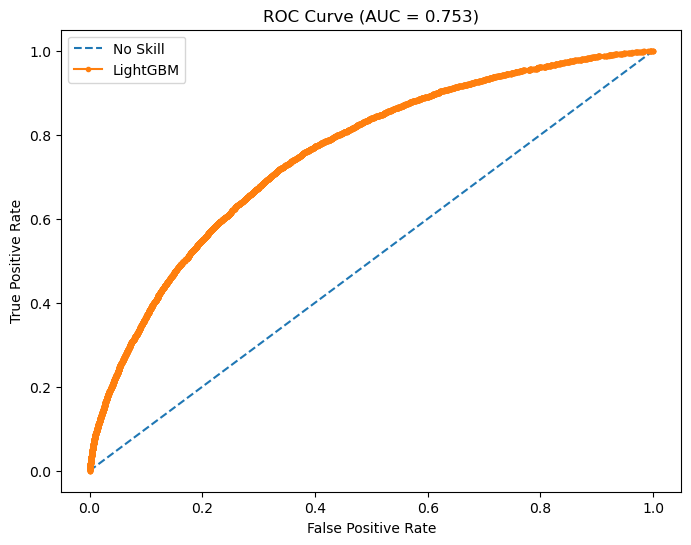

Area Under the Curve (AUC): 0.753


In [148]:
yhat = prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate AUC
roc_auc = auc(fpr, tpr)

# plot the ROC curve for the model
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LightGBM')
plt.title(f'ROC Curve (AUC = {roc_auc:.3f})')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

# print the AUC
print(f'Area Under the Curve (AUC): {roc_auc:.3f}')

El valor de AUC (Área Bajo la Curva) de 0.753 es una métrica positiva para el modelo. En un problema de clasificación binaria, el AUC es una medida que evalúa la capacidad del modelo para distinguir entre las clases positivas y negativas. Un AUC cercano a 1 indica un modelo que puede separar perfectamente las clases, mientras que un AUC de 0.5 indicaría un modelo que no tiene capacidad de discriminación y solo está lanzando una predicción aleatoria.

Un AUC de 0.753 es un buen indicador de rendimiento para este tipo de problema, especialmente considerando que se trata de un problema de clasificación con una clase muy desbalanceada. Esto sugiere que el modelo es capaz de predecir correctamente la clase positiva en la mayoría de los casos, aunque no lo hace perfectamente.

In [149]:
gmeans = np.sqrt(tpr * (1-fpr))

In [150]:
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.487347, G-Mean=0.690


El G-Mean es la raíz cuadrada de la precisión y el recall, es decir, la raíz cuadrada del producto de la tasa de verdaderos positivos y la tasa de verdaderos negativos.

Un G-Mean cercano a 0.7 es un indicativo positivo del rendimiento del modelo, ya que sugiere que el modelo es capaz de identificar correctamente tanto las instancias positivas como las negativas en una proporción balanceada.

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


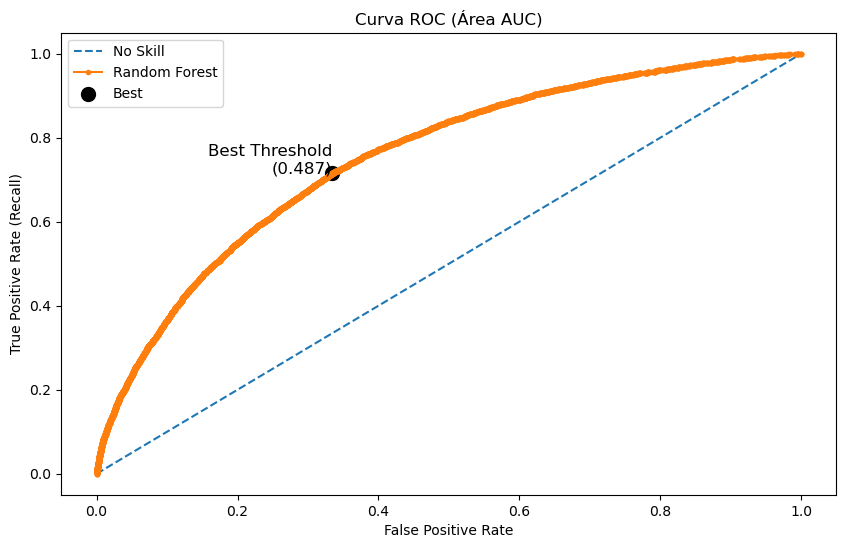

In [151]:
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test_scaled_filtered)[:, 1])

# Determinar el mejor punto de corte según la curva ROC
ix = np.argmax(tpr - fpr)  # El índice del mejor punto

# Graficar la curva ROC
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')  # Línea de referencia
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')

# Etiquetas de los ejes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC (Área AUC)')
plt.legend()

# Mostrar el valor del umbral óptimo 'Best'
best_threshold = thresholds[ix]
best_fpr = fpr[ix]
best_tpr = tpr[ix]
plt.text(best_fpr, best_tpr, f'Best Threshold\n({best_threshold:.3f})', fontsize=12, ha='right')

plt.show()

Aqui se muestra el 'Best Threshold" para el modelo, en este caso, 0.487

In [152]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, yhat)

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


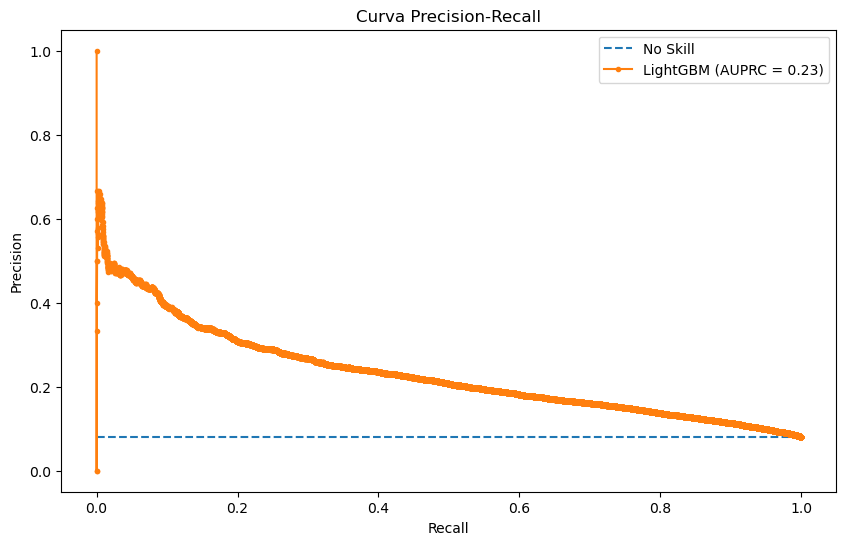

In [153]:
precision, recall, _ = precision_recall_curve(y_test, best_model.predict_proba(X_test_scaled_filtered)[:, 1])

# Área bajo la curva Precision-Recall (AUPRC)
auprc = auc(recall, precision)

# Línea de referencia (sin habilidad)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# Curva Precision-Recall del modelo LightGBM
plt.plot(recall, precision, marker='.', label=f'LightGBM (AUPRC = {auprc:.2f})')

# Etiquetas de los ejes
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

C:\Users\pablo\AppData\Local\Temp\ipykernel_12696\2968667079.py:1: RuntimeWarning: invalid value encountered in divide
  fscore = np.where((precision + recall) > 0, (2 * precision * recall) / (precision + recall), 0)


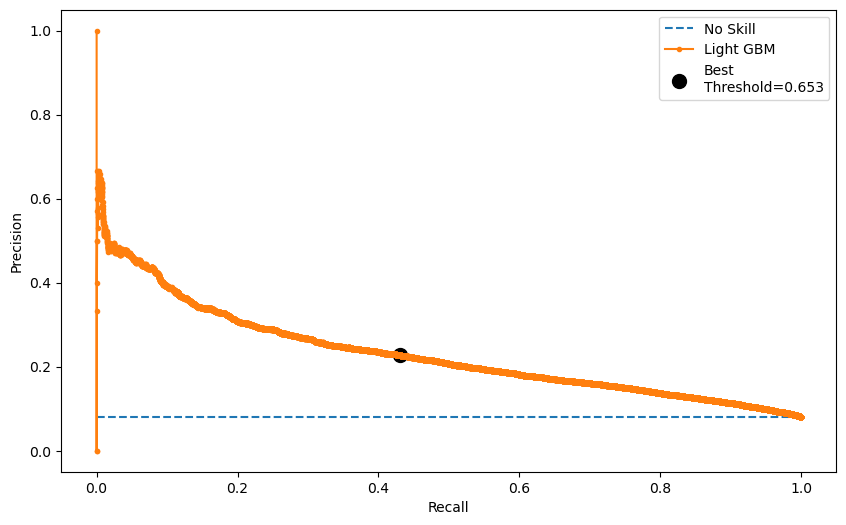

In [154]:
fscore = np.where((precision + recall) > 0, (2 * precision * recall) / (precision + recall), 0)
# locate the index of the largest f score
ix = np.argmax(fscore)
best_threshold = thresholds[ix]

# plot the ROC curve for the model
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Light GBM')
plt.scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label=f'Best\nThreshold={best_threshold:.3f}')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

El valor de 0.653 como "best threshold" sugiere que para probabilidades superiores a 0.653, el modelo clasifica un ejemplo como clase 1, y para probabilidades inferiores a este umbral, clasifica como clase 0.

El valor del "best threshold" de 0.653 es un indicador de que el modelo ha encontrado un equilibrio óptimo entre la precisión y el recall para discriminar entre las clases. Este umbral es el punto donde la combinación de estas métricas es máxima, lo que sugiere que el modelo está haciendo una buena distinción entre las clases de interés.

In [155]:
score = f1_score(y_test, predictions)
print('F-Score: %.5f' % score)

F-Score: 0.26169


En problemas de clasificación desbalanceada es este caso (Se distribuye 92/8), el F-Score tiende a ser más bajo ya que el modelo esta más inclinado a clasificar la mayoría de los datos en la clase mayoritaria.

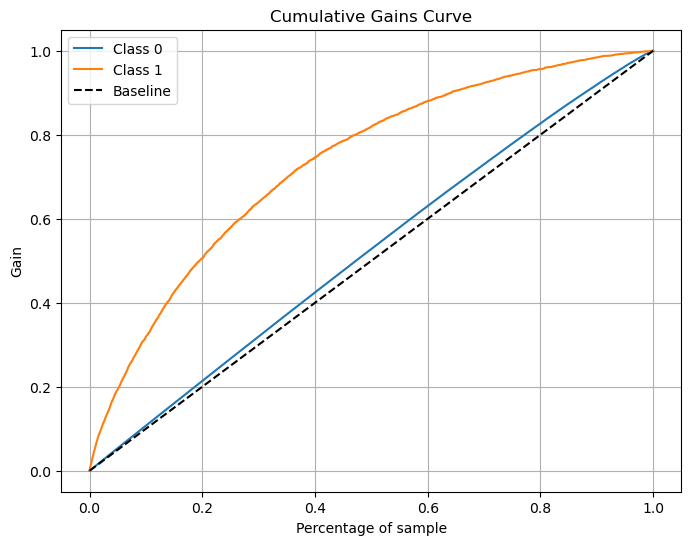

In [156]:
def cumulative_gain(y_true, prob_pred):
    """
    Calcula la ganancia acumulada para cada clase.
    """
    gains = {}
    unique_classes = np.unique(y_true)
    for class_label in unique_classes:
        # Obtener las probabilidades de la clase actual
        prob_class = prob_pred[:, class_label] if prob_pred.ndim > 1 else prob_pred
        
        # Etiquetas binarizadas (1 para la clase actual, 0 para las demás)
        y_true_binary = (y_true == class_label).astype(int)
        
        # Ordenar por probabilidades
        order = np.argsort(prob_class)[::-1]
        y_true_sorted = y_true_binary[order]
        
        # Cálculo de la ganancia acumulada
        cumulative_gain = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
        cumulative_gain = np.insert(cumulative_gain, 0, 0)  # Agregar 0 al inicio
        
        # Guardar resultados
        gains[class_label] = (np.linspace(0, 1, len(cumulative_gain)), cumulative_gain)
    
    return gains

# Calcula las ganancias acumuladas para las clases 0 y 1
gains = cumulative_gain(y_test, prob_predictions)

# Graficar
plt.figure(figsize=(8, 6))
for class_label, (recall, gain) in gains.items():
    plt.plot(recall, gain, label=f'Class {class_label}')

# Línea de modelo aleatorio (Baseline)
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')

# Agregar leyenda
plt.legend()

# Configurar etiquetas y título
plt.title('Cumulative Gains Curve')
plt.xlabel('Percentage of sample')
plt.ylabel('Gain')
plt.grid(True)
plt.show()

Ambas clases estan por encima de la línea de referencia, esto indica que el modelo está haciendo una clasificación efectiva y está encontrando un mayor número de casos positivos de lo que sería esperable por azar. Aun así, la clase 0 no lo hace mucho mejor que si fuera aleatoriamente.

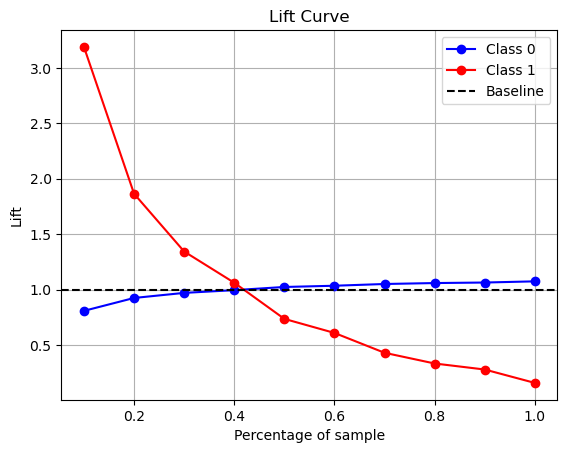

In [157]:
def plot_lift_curve(y_true, y_probs, num_bins=10):
    # Inicializamos las listas de lift para las dos clases
    lift_class_0 = []
    lift_class_1 = []
    
    # Ordenamos las probabilidades predichas de mayor a menor para ambas clases
    order = np.argsort(y_probs[:, 1])[::-1]
    y_true_sorted = y_true[order]
    y_probs_sorted = y_probs[order]
    
    # Dividir las probabilidades en bins
    bin_size = len(y_true) // num_bins
    for i in range(num_bins):
        start = i * bin_size
        end = (i + 1) * bin_size if i < num_bins - 1 else len(y_true)
        
        # Tomar las verdaderas etiquetas para este bin
        y_bin = y_true_sorted[start:end]
        
        # Calcular el lift para la clase 0 y la clase 1
        lift_class_0.append(np.mean(y_bin == 0) / np.mean(y_true == 0))
        lift_class_1.append(np.mean(y_bin == 1) / np.mean(y_true == 1))
    
    # Generar el eje X con los percentiles (bins)
    x_bins = np.linspace(0, 1, num_bins + 1)[1:]
    
    # Graficar las Lift Curves
    plt.plot(x_bins, lift_class_0, marker='o', color='b', label='Class 0')
    plt.plot(x_bins, lift_class_1, marker='o', color='r', label='Class 1')
    
    # Línea de referencia (baseline)
    plt.axhline(y=1, color='k', linestyle='--', label='Baseline')
    
    # Configuración de la gráfica
    plt.xlabel('Percentage of sample')
    plt.ylabel('Lift')
    plt.title('Lift Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Uso de la función para graficar la Lift Curve
plot_lift_curve(y_test, prob_predictions, num_bins=10)

Clase 0 : Comienza por debajo de 1, lo que indica que en los primeros porcentajes de la muestra, el modelo tiene un rendimiento inferior al modelo aleatorio en la identificación de la clase negativa. Sin embargo, a medida que el porcentaje de muestra clasificada aumenta, el "Lift" también lo hace, mostrando que el modelo encuentra más correctamente los casos negativos a medida que clasifica más datos.

Clase 1 : Comienza por encima de 1 y luego tiende a estabilizarse o disminuir, lo que sugiere que el modelo es más efectivo inicialmente en identificar la clase positiva, pero su rendimiento mejora menos cuando se clasifican más datos adicionales. En problemas de clases desbalanceadas, es común que el modelo clasifique mejor las clases minoritarias inicialmente, pero a medida que más datos se consideran, este rendimiento no mejora tanto o incluso podría empeorar.

En resumen, el gráfico de la "Lift Curve" en nuestro problema desbalanceado muestra una imagen positiva de cómo el modelo está manejando las clases desbalanceadas, destacando su capacidad para mejorar en la identificación de las clases menos representadas conforme más datos se procesan.

# CONCLUSIONES DEL MODELO FINAL

El modelo LightGBM ha demostrado un rendimiento aceptable con un recall de aproximadamente 0.7 en un problema de clasificación con clases altamente desbalanceadas (proporción 92/8). Este desempeño es indicativo de que el modelo es capaz de identificar correctamente una buena parte de las instancias de la clase minoritaria (clase 1). Sin embargo, es crucial evaluar el modelo utilizando más métricas para obtener una visión completa de su eficacia.

Las métricas adicionales, como la precisión, el F1-score y la curva ROC, proporcionan una evaluación más general del modelo. Específicamente, la precisión y el F1-score son bajos (0.16), lo que indica que el modelo enfrenta dificultades para identificar correctamente las instancias de la clase minoritaria. Este es un reto esperado en problemas desbalanceados, donde la predicción errónea tiende a ser de la clase mayoritaria. Aunque la matriz normalizada muestra un manejo efectivo de la clase 1 en términos de precisión, los errores fuera de la diagonal reflejan que el modelo aún enfrenta dificultades al clasificar correctamente las instancias de la clase minoritaria.

El valor de AUC (Área Bajo la Curva) de 0.753 es una métrica positiva para el modelo, indicando una buena capacidad para distinguir entre las clases. Un AUC cercano a 1 sugiere que el modelo tiene una capacidad significativa para separar las clases, mientras que un AUC de 0.5 indicaría un modelo que solo predice aleatoriamente. En este contexto, un AUC de 0.753 sugiere que el modelo es capaz de predecir correctamente la clase positiva en la mayoría de los casos, aunque no lo haga perfectamente.

El G-Mean es la raíz cuadrada del producto de la precisión y el recall y es un indicador positivo del rendimiento del modelo. Un G-Mean cercano a 0.7 sugiere que el modelo es capaz de identificar tanto las instancias positivas como las negativas de manera equilibrada. Aquí se muestra el 'Best Threshold' para el modelo, en este caso, 0.487. Este valor sugiere que para probabilidades superiores a 0.653, el modelo clasifica un ejemplo como clase 1, y para probabilidades inferiores a este umbral, clasifica como clase 0. Esto indica que el modelo ha encontrado un equilibrio óptimo entre la precisión y el recall para discriminar entre las clases.

El valor del "best threshold" de 0.653 es un indicador de que el modelo ha encontrado un punto óptimo para discriminar entre las clases. Este umbral es donde la combinación de precisión y recall es máxima, lo que sugiere que el modelo está haciendo una buena distinción entre las clases de interés. En este problema de clasificación desbalanceada, como este caso (proporción 92/8), el F-Score tiende a ser más bajo ya que el modelo tiende a clasificar la mayoría de los datos en la clase mayoritaria. Ambas clases están por encima de la línea de referencia, lo que indica que el modelo está encontrando más casos positivos de lo que sería esperado por azar.

**En cuanto a la Lift Curve**

Clase 0: Comienza por debajo de 1, lo que sugiere que en los primeros porcentajes de la muestra, el modelo tiene un rendimiento inferior al modelo aleatorio en la identificación de la clase negativa. A medida que el porcentaje de muestra clasificada aumenta, el "Lift" también mejora, mostrando que el modelo identifica más correctamente los casos negativos.

Clase 1: Comienza por encima de 1 y luego tiende a estabilizarse o disminuir, lo que sugiere que el modelo es más efectivo inicialmente en identificar la clase positiva, pero su rendimiento mejora menos cuando se clasifican más datos adicionales. En problemas de clases desbalanceadas, es común que el modelo clasifique mejor las clases minoritarias inicialmente, pero a medida que se procesan más datos, este rendimiento no mejora tanto o incluso podría empeorar.

En resumen, el gráfico de la "Lift Curve" en nuestro problema desbalanceado muestra una imagen positiva de cómo el modelo está manejando las clases desbalanceadas, destacando su capacidad para mejorar en la identificación de las clases menos representadas conforme más datos se procesan. Ajustar los umbrales de clasificación o explorar métodos como el re-sampling podría mejorar la identificación de la clase minoritaria y aumentar el rendimiento general del modelo.

In [158]:
train = pd.concat([X_train_scaled_filtered, y_train], axis=1)
test = pd.concat([X_test_scaled_filtered, y_test], axis=1)

In [159]:
test.head()

,EXT_SOURCE_1,OCCUPATION_TYPE,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_QRT,DEF_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE,CODE_GENDER_1,...,FLAG_DOCUMENT_16,AMT_CREDIT,REG_CITY_NOT_LIVE_CITY,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,FLAG_WORK_PHONE,DAYS_ID_PUBLISH,NAME_EDUCATION_TYPE_1,NAME_EDUCATION_TYPE_3,TARGET
0,-2.372710,1.272866,1.366485,0.987603,-0.323735,0.733422,-0.812778,0.145443,0.377622,-1.389066,...,-0.10013,-0.818320,-0.291707,-0.062963,0.629004,-0.500180,0.067672,0.638708,-0.567136,0
1,0.012931,-0.737007,1.404387,-0.294248,-0.323735,-0.145941,0.089128,-0.085558,-0.319181,0.719908,...,-0.10013,0.493191,-0.291707,-0.062963,0.652918,-0.500180,-0.668007,0.638708,-0.567136,0
2,2.025527,-0.818769,0.060498,0.987603,-0.323735,1.405447,0.150068,-0.735908,0.017123,0.719908,...,-0.10013,-0.013228,-0.291707,-2.053105,0.629004,1.999279,1.000858,0.638708,-0.567136,0
3,1.196749,-0.737007,0.111918,-0.294248,-0.323735,0.065809,-0.849342,-0.969399,-0.551448,0.719908,...,-0.10013,-0.634904,-0.291707,1.927180,-1.109856,-0.500180,-0.371747,0.638708,-0.567136,0
4,1.570854,0.715513,-0.483988,-0.294248,-0.323735,-1.144526,-0.910282,-0.684229,-1.849485,0.719908,...,-0.10013,-0.786744,-0.291707,1.927180,0.629004,1.999279,-1.184308,0.638708,-0.567136,0


In [163]:
train.head()

,EXT_SOURCE_1,OCCUPATION_TYPE,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_QRT,DEF_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE,CODE_GENDER_1,...,FLAG_DOCUMENT_16,AMT_CREDIT,REG_CITY_NOT_LIVE_CITY,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,FLAG_WORK_PHONE,DAYS_ID_PUBLISH,NAME_EDUCATION_TYPE_1,NAME_EDUCATION_TYPE_3,TARGET
0,0.012931,-0.737007,0.950260,-0.294248,-0.323735,1.246123,-0.727463,-0.018001,0.377622,0.719908,...,-0.10013,-0.782853,-0.291707,-2.053105,-1.368292,-0.500180,0.198901,0.638708,-0.567136,0
1,0.012931,1.162103,0.111918,0.987603,-0.323735,0.391968,-0.849342,-0.123228,1.102248,-1.389066,...,-0.10013,-0.856292,-0.291707,1.927180,0.985387,-0.500180,-1.079590,0.638708,-0.567136,1
2,-0.513031,-0.737007,-2.418920,-0.294248,1.948554,0.559260,-0.179006,-0.124784,-1.347449,0.719908,...,-0.10013,-0.012926,-0.291707,-0.062963,0.264630,-0.500180,1.906870,-1.565660,-0.567136,0
3,0.268820,0.715513,1.081943,-0.294248,-0.323735,0.733992,0.369450,0.380491,0.690941,0.719908,...,-0.10013,0.188033,-0.291707,-0.062963,0.985387,-0.500180,-0.585823,0.638708,-0.567136,0
4,-1.082039,0.715513,0.728806,0.987603,-0.323735,-1.098058,-1.056537,-0.956324,-1.609960,0.719908,...,-0.10013,-1.071463,-0.291707,1.927180,0.629004,1.999279,-0.207379,0.638708,-0.567136,0


In [162]:
train.to_csv("../data/train_model.csv")
test.to_csv("../data/test_model.csv")